# Hydraulic Design

"""
@file   md_infrastructure.py
@author  Natalia Duque <natalia.duquevillarreal@eawag.ch>
@section LICENSE

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

__author__ = "Natalia Duque"
__copyright__ = "Copyright 2018."

## Step 0. Import python packages

In [1]:
# region --- PYTHON LIBRARY IMPORTS ---
import time
from math import *
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.colors as colors
%matplotlib inline
# --- Spatial geometry ---
from shapely.geometry import Point, Polygon, LineString

# --- SND IMPORTS ---
# from help_functions.helper_functions import verbose_, cm2inch, truncate_colormap, set_file_name
from ssnd.algorithm import *
from ssnd.defaults import *
from ssnd.help_functions.helper_functions import *
from ssnd.help_functions.plot_maps import *
from ssnd.deterioration import *
#endregion 

module="hydraulic_design"
read_module = "topology"

connectivity = connectivity
case_study = case_study

## Step 1 Initialization

In [2]:
# Input parameters

# for PVC Pipes  
roughness, n = get_roughness(material=material)

path = DATA_DIR/case_study/"output/shp"
output_path = DATA_DIR /case_study/"output"

blocks_dict=dict()
pipes_dict = dict()

verbose=False
notify = True
plot = False

Get topology shape files

In [3]:
run_step_by_step = False

In [4]:
year=2018
name= name_pipes
path_blocks=path/read_module/fr"{connectivity.lower()}_{case_study}_{name}_({year})/{connectivity.lower()}_{case_study}_{name}_({year}).shp"
print(path_blocks)
df = gpd.read_file(path_blocks)
# blocks_dict[year]=blocks

df[df['BlockID']==672]

c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\Data\data\Uster_200_200L\output\shp\topology\centralised_Uster_200_200L_pipes_(2018)\centralised_Uster_200_200L_pipes_(2018).shp


KeyboardInterrupt: 

In [ ]:
""" READ INPUT FILE """
# Working path and input file
if run_step_by_step:

    for year in range(year_i, year_f+1, year_step):
        path_blocks=path/read_module/fr"{connectivity.lower()}_{case_study}_blocks_({year})/{connectivity.lower()}_{case_study}_blocks_({year}).shp"
        blocks = gpd.read_file(path_blocks)
        print(path_blocks)
        blocks_dict[year]=blocks
        
        path_pipes=path/read_module/f"{connectivity.lower()}_{case_study}_pipes_({year})/{connectivity.lower()}_{case_study}_pipes_({year}).shp"
        pipes = gpd.read_file(path_pipes)
        print(path_pipes)
        pipes_dict[year]=pipes

In [ ]:
if run_step_by_step:

    display(pipes_dict[2018])
    display(pipes_dict[2038])

In [ ]:
if run_step_by_step:blocks_dict[2018][blocks_dict[2018]['BlockID']==671]

In [ ]:
if run_step_by_step:

    display(blocks_dict[2018])
    display(blocks_dict[2038])

duplicate columns with names for HD

In [ ]:
def duplicate_columns_with_new_name(df:gpd.GeoDataFrame, columns:list, new_columns:list):
    if df is not None:
        for i,  col in enumerate(columns):
            new_col = new_columns[i]
            df[new_col] = df[col]
        
    return df.copy()

In [ ]:
if run_step_by_step:

    columns = ['BlockID', 'CentreX', 'CentreY', 'blk_elev', 'has_wwtp', 'id_up', 'id_down', 'pipe_loc', 'desg_flow' ]
    new_columns = ['id', 'x', 'y', 'z', 'outlet', 'id_up', 'id_down', 'type', 'desg_flow']

    for year in range(year_i, year_f+1, year_step):
        blocks = blocks_dict[year]
        blocks = duplicate_columns_with_new_name(df=blocks, columns=columns, new_columns=new_columns)
        display(blocks.loc[blocks["has_infra"]>=1,new_columns])

        pipes = pipes_dict[year]
        pipes = duplicate_columns_with_new_name(df=pipes, columns=columns, new_columns=new_columns)
        display(pipes[new_columns])

Create new columns in dataframe

In [ ]:
def df_with_new_fields (df:pd.DataFrame, module:str="topology", verbose:bool=False):
    """ Initialize new columns for current module in the Dataframe     

    """

    if module.lower().__contains__("topo"):
        columns = ["dem_sink",
                "blk_elev",
                "edge",         # binary: 1 if the block is on the edge (boundary) of the case study 
                "carved",       # binary: 1 if the block has been carved
                "has_ww",       # binary: 1 if the block has sewer requirements
                "has_infra",     # binary: 1 if the block already has infrastructure
                "has_wwtp",      # binary: 1 if the block has a WWTP
                "id_up",        # int: upstream ID
                "id_down",      # int: downstream ID
                "has_outlet",   # binary: 1 if the block has a an outlet (sink) of a sewersubcatchment
                "link_type",    # binary: 1 for external pipes, 2 for internal pipes
                "type_sewer",   # str: "collection" or "trunk" pipes
                "id_basin",    # int: sewer basin No.
                "horiz_dist",   # float: length of the sewer link
                "elev_drop",    # float: elevation difference of the sewer pipe
                "terr_slope",   # float: terrain slope
                "near_wwtp",    # int: ID of nearest WWTP
                "near_river",   # int: ID of nearest River         
                "ww_inflow",    # float: Flow coming into the Block (upstrem manhole)
                "peak_flow",    # float: Daily peak flow produced in the Block
                "PE",           # Population Equivalents 
                "desg_flow",    # float: Design flow considering the design factor and the peak flow.
                "up_ids",       # str: list of IDs of upstream blocks
                "down_ids",     # str: list of IDs of downstream blocks
                "built_year"    # int: construction year
                ]

    if module.lower().__contains__("hydr"):
        columns = ["diameter",      # pipe diameter [m]
        "slope",        # pipe slope
        "sww_length",    # pipe length
        "fill_ratio",   # filling ration
        "y_max",        # maximum flow depth
        "y_n",           # normal flow depth
        "angle",        # internal angle for circular pipes
        "perimeter",    # wet perimeter
        "top_width",     # top width
        "h_radius",       # hydraulic_radius
        "area",         # wet area
        "velocity",     # flow velocity
        "shear",        # shear stress
        "froude",       # Froude number
        "exact_flow"]   # current flow in the pipe

        for col in columns:
            df[col] = 0.0
    
    else: 
        return df.copy()

    

    return df.copy()

In [ ]:
if run_step_by_step:
   
    for year in range(year_i, year_f+1, year_step):
        blocks = blocks_dict[year]
        blocks = df_with_new_fields (df=blocks, module=module, verbose=verbose)
        display(blocks[blocks.columns[-16:]])

        pipes = pipes_dict[year]
        pipes = df_with_new_fields (df=pipes, module=module, verbose=verbose)
        display(pipes[pipes.columns[-16:]])

In [ ]:
if run_step_by_step:

    display(blocks[blocks["outlet"]>0])

Prepare hydraulics for each pipe diameter using maximum filling ratio 

In [ ]:
def prepare_hydraulics_data(diameters=commercial_diameters, v_min=0.75, v_max=10.0, n=0.009, verbose=False):
    """Prepare arrays with the minimum and maximum slope based on the minimum and maximum velocities
    assuming a maximum filling ratio for the each diameter.

    :param diameters: list of commercial diameters in m
    :param v_min: minimum velocity
    :param v_max: maximum velocity
    :param n: Manning's n coefficient
    :param verbose: printing function
    :return: df_df_hydraulics data frame with hydraulic parameters

    """

    # Prepare arrays for the hydraulic calculations
    max_hydraulic_radius = []
    max_areas = []
    min_slopes = []
    max_slopes = []

    # calculating the max filling ratio and the min slopes
    for idx, diameter in enumerate(diameters):
        verbose_(idx, verbose)
        # Hydraulic parameters for the maximum filling ratio of the pipe with a specific diameter
        y = get_max_flow_depth(diameter)
        angle = get_angle(diameter, y)
        max_hydraulic_radius.append(get_hydraulic_radius(diameter, angle))
        max_areas.append(get_area(diameter, angle))
        verbose_("max_hydraulic_radius: {}".format(max_hydraulic_radius), verbose)
        verbose_("max_areas: {}".format(max_areas), verbose)

        # Calculate minimum and maximum slope for the given diameter

        min_slopes.append(round(get_slope(max_hydraulic_radius[-1], v_min, n),6)+1E-6)
        max_slopes.append(round(get_slope(max_hydraulic_radius[-1], v_max, n),6)-1E-6)
        verbose_("min_slopes: {}".format(min_slopes), verbose)
        verbose_("max_slopes: {}".format(max_slopes), verbose)

    dict = {
        "diameter": diameters,
        "min_slopes": min_slopes,
        "max_slopes": max_slopes,
        "max_hydraulic_radius": max_hydraulic_radius,
        "max_areas": max_areas,
    }

    # columns= {"min_slopes", "max_slopes", "max_hydraulic_radius", "max_areas"}
    df_hydraulics = pd.DataFrame.from_dict(dict)
    # list(df_hydraulics["max_hydraulic_radius"])
    verbose_("Hydraulic parameters for each pipe diameter under max filling ratio", verbose)
    verbose_("df_hydraulics \n".format(df_hydraulics), verbose)

    return df_hydraulics

In [ ]:
if run_step_by_step:
    df_hydraulics = prepare_hydraulics_data(diameters=commercial_diameters, v_min=v_min, v_max=v_max, n=n, verbose=False)
    display(df_hydraulics)

Find best diameter slope

In [ ]:
def get_diameter_for_max_filling_ratio(pipe,
                                       incoming_diameter_idx,
                                        df_hydraulics,
                                        diameters=commercial_diameters,):
       
    for idx in range(incoming_diameter_idx, len(diameters)):
        diameter: float = diameters[idx]
        
        max_hyd_rad = df_hydraulics.max_hydraulic_radius[idx]
        max_area = df_hydraulics.max_areas[idx]
        min_slope = df_hydraulics.min_slopes[idx]
        max_slope = df_hydraulics.max_slopes[idx]
        
        pipes[flow]

In [ ]:
# def find_best_diameter_slope(
#     pipes,
#     df_hydraulics,
#     id_up,
#     design_discharge,
#     ideal_slope,
#     incoming_diameter_idx=0,
#     v_min=0.75,
#     v_max=10.0,
#     n=0.009,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
#     roughness=0.00003,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
#     min_discharge=0.000001,
#     min_slope_limit=0.0001,
#     max_slope_limit=0.1,
#     delta_slope=0.0001,
#     diameters=commercial_diameters,
#     verbose=False,
#     count=0,
# ):
#     """Find a diameter-slope feasible combination for each pipe

#     :param pipes: dataframe with pipes information [id_up, id_down, type, design-flow]
#     :param id_up: ID of the pipe, given by the ID of its upstream manhole
#     :param design_discharge: design flow of the pipe to be designed

#     :param v_min: minimum flow velocity limit default: 0.75
#     :param v_max: maximum flow velocity limit default: 10.0
#     :param min_slope_limit: minimum slope limit default: 0.001
#     :param max_slope_limit: maximum slope limit default: 0.10
#     :param delta_slope: slope change default:0.0001
#     :param diameters: list of commercial diameters
#                       default:[0.225, 0.25, 0.35, 0.4, 0.5, 0.6, 0.80, 1.0, 1.20, 1.5, 2.0, 2.5, 3.0]
#     :param verbose: Boolean, print statements if True

#     :return slope: design slope for the pipe
#     :return diameter: selected pipe diameter in meters [m]
#     """
#     checked_hydraulics = False
    
#     # for pipes with almost no discharge
#     if design_discharge < min_discharge:
#         design_discharge = min_discharge * 10  # discharge for a household with 10 people


#     # loop over diameters starting from the diameter of the previous manhole that is given as input.
#     for idx in range(incoming_diameter_idx, len(diameters)):
#         diameter: float = diameters[idx]
#         pipe_idx = pipes[pipes["id_up"]==id_up].index[0]

#         max_hyd_rad = df_hydraulics.max_hydraulic_radius[idx]
#         max_area = df_hydraulics.max_areas[idx]
#         min_slope = df_hydraulics.min_slopes[idx]
#         max_slope = df_hydraulics.max_slopes[idx]

#         # set start slope values at the minimum slope for the following iterations
#         if min_slope <= ideal_slope <= max_slope:
#             start_slope = ideal_slope
#         else:
#             start_slope = min_slope

#         velocity = v_min

#         # max_slope is the minimum slope between the slope limit defined in defaults (e.g. 10%)
#         # and the max_slope for the pipe diameter
#         max_s = min(max_slope_limit, max_slope)

#         for slope in np.arange(start_slope, max_s, delta_slope):

#             if velocity > v_max:
#                 continue

#             else: 
#                 # make sure discharge fits through the pipe
#                 max_discharge = max_area * get_velocity(slope, max_hyd_rad, n)

#                 if design_discharge < max_discharge:

#                     # calculate the real flow depth
#                     y_n, exact_flow = get_normal_depth(diameter, design_discharge, slope, n)

#                     # recalculate geometric parameters
#                     angle = get_angle(diameter, y_n)
#                     h_radius = get_hydraulic_radius(diameter, angle)
#                     area = get_area(diameter, angle)

#                     # recalculate hydraulic parameters
#                     velocity = get_velocity(slope, h_radius, n)
#                     tau = get_tau(slope, h_radius)
#                     top_width = get_top_width(diameter, angle)
#                     froude = get_froude(area, velocity, top_width)

#                     # check hydraulic constraints
#                     checked_hydraulics = check_constraints(diameter, velocity, tau, y_n, froude, roughness)

#                     if checked_hydraulics:
#                         verbose_(f" FOUND IT {id_up} {diameter} {slope}", verbose=verbose)
#                         # Add values for the hydraulic design to data frame
#                         pipes.loc[pipe_idx, "diameter"] = diameter
#                         pipes.loc[pipe_idx, "slope"] = slope
#                         pipes.loc[pipe_idx, "fill_ratio"] = y_n / diameter
#                         pipes.loc[pipe_idx, "y_n"] = y_n
#                         pipes.loc[pipe_idx, "angle"] = angle
#                         pipes.loc[pipe_idx, "h_radius"] = h_radius
#                         pipes.loc[pipe_idx, "area"] = area
#                         pipes.loc[pipe_idx, "velocity"] = velocity
#                         pipes.loc[pipe_idx, "froude"] = froude
#                         pipes.loc[pipe_idx, "tau"] = tau
#                         pipes.loc[pipe_idx, "exact_flow"] = exact_flow
#                         return slope, diameter
    
#     while not checked_hydraulics:
#         slope: float = ideal_slope
#         diameter: float = diameters[incoming_diameter_idx]
        
#         max_hyd_rad = df_hydraulics.max_hydraulic_radius[incoming_diameter_idx]
#         max_area = df_hydraulics.max_areas[incoming_diameter_idx]
#         min_slope = df_hydraulics.min_slopes[incoming_diameter_idx]
#         max_slope = df_hydraulics.max_slopes[incoming_diameter_idx]
        
#         # make sure discharge fits through the pipe
#         max_discharge = max_area * get_velocity(slope, max_hyd_rad, n)

#         if design_discharge < max_discharge:

#             # calculate the real flow depth
#             y_n, exact_flow = get_normal_depth(diameter, design_discharge, slope, n)

#             # recalculate geometric parameters
#             angle = get_angle(diameter, y_n)
#             h_radius = get_hydraulic_radius(diameter, angle)
#             area = get_area(diameter, angle)

#             # recalculate hydraulic parameters
#             velocity = get_velocity(slope, h_radius, n)
#             tau = get_tau(slope, h_radius)
#             top_width = get_top_width(diameter, angle)
#             froude = get_froude(area, velocity, top_width)

#             # check hydraulic constraints
#             checked_hydraulics = True

#             if checked_hydraulics:
#                 verbose_(f" FOUND IT {id_up} {diameter} {slope}", verbose=verbose)
#                 # Add values for the hydraulic design to data frame
#                 pipes.loc[pipe_idx, "diameter"] = diameter
#                 pipes.loc[pipe_idx, "slope"] = slope
#                 pipes.loc[pipe_idx, "fill_ratio"] = y_n / diameter
#                 pipes.loc[pipe_idx, "y_n"] = y_n
#                 pipes.loc[pipe_idx, "angle"] = angle
#                 pipes.loc[pipe_idx, "h_radius"] = h_radius
#                 pipes.loc[pipe_idx, "area"] = area
#                 pipes.loc[pipe_idx, "velocity"] = velocity
#                 pipes.loc[pipe_idx, "froude"] = froude
#                 pipes.loc[pipe_idx, "tau"] = tau
#                 pipes.loc[pipe_idx, "exact_flow"] = exact_flow
#                 return slope, diameter
#         else:
#             incoming_diameter_idx +=1
            
#             if incoming_diameter_idx == len(diameters):
#                 break
         
        
        
        
#     return slope, diameter

In [ ]:
def find_best_diameter_slope(
    pipes,
    df_hydraulics,
    id_up,
    design_discharge,
    ideal_slope,
    incoming_diameter_idx=0,
    v_min=0.75,
    v_max=10.0,
    n=0.009,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
    roughness=0.00003,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
    min_discharge=0.000001,
    min_slope_limit=0.0001,
    max_slope_limit=0.1,
    delta_slope=0.0001,
    diameters=commercial_diameters,
    verbose=False,
    count=0,
):
    """Find a diameter-slope feasible combination for each pipe

    :param pipes: dataframe with pipes information [id_up, id_down, type, design-flow]
    :param id_up: ID of the pipe, given by the ID of its upstream manhole
    :param design_discharge: design flow of the pipe to be designed

    :param v_min: minimum flow velocity limit default: 0.75
    :param v_max: maximum flow velocity limit default: 10.0
    :param min_slope_limit: minimum slope limit default: 0.001
    :param max_slope_limit: maximum slope limit default: 0.10
    :param delta_slope: slope change default:0.0001
    :param diameters: list of commercial diameters
                      default:[0.225, 0.25, 0.35, 0.4, 0.5, 0.6, 0.80, 1.0, 1.20, 1.5, 2.0, 2.5, 3.0]
    :param verbose: Boolean, print statements if True

    :return slope: design slope for the pipe
    :return diameter: selected pipe diameter in meters [m]
    """
    checked_hydraulics = False
    
    # for pipes with almost no discharge
    if design_discharge < min_discharge:
        design_discharge = min_discharge * 10  # discharge for a household with 10 people

    # set start slope values at the minimum slope for the following iterations
    if min_slope_limit <= ideal_slope <= max_slope_limit:
        start_slope = ideal_slope
    else:
        start_slope = df_hydraulics.min_slopes[0]

    velocity = v_min

    # max_slope is the minimum slope between the slope limit defined in defaults (e.g. 10%)
    # and the max_slope for the pipe diameter
    max_s = max_slope_limit

    for slope in np.arange(start_slope, max_s, delta_slope):
            
        # loop over diameters starting from the diameter of the previous manhole that is given as input.
        for idx in range(incoming_diameter_idx, len(diameters)):
            diameter: float = diameters[idx]
            pipe_idx = pipes[pipes["id_up"]==id_up].index[0]

            max_hyd_rad = df_hydraulics.max_hydraulic_radius[idx]
            max_area = df_hydraulics.max_areas[idx]
            min_slope = df_hydraulics.min_slopes[idx]
            max_slope = df_hydraulics.max_slopes[idx]

            # set start slope values at the minimum slope for the following iterations
            if min_slope <= slope <= max_slope:
                # make sure discharge fits through the pipe
                velocity = get_velocity(slope, max_hyd_rad, n)
                if velocity > v_max:
                    continue
            
                max_discharge = max_area * velocity

                if design_discharge < max_discharge:

                    # calculate the real flow depth
                    y_n, exact_flow = get_normal_depth(diameter, design_discharge, slope, n)

                    # recalculate geometric parameters
                    angle = get_angle(diameter, y_n)
                    h_radius = get_hydraulic_radius(diameter, angle)
                    area = get_area(diameter, angle)

                    # recalculate hydraulic parameters
                    velocity = get_velocity(slope, h_radius, n)
                    tau = get_tau(slope, h_radius)
                    top_width = get_top_width(diameter, angle)
                    froude = get_froude(area, velocity, top_width)

                    # check hydraulic constraints
                    checked_hydraulics = check_constraints(diameter, velocity, tau, y_n, froude, roughness)

                    if checked_hydraulics:
                        verbose_(f" FOUND IT {id_up} {diameter} {slope}", verbose=verbose)
                        # Add values for the hydraulic design to data frame
                        pipes.loc[pipe_idx, "diameter"] = diameter
                        pipes.loc[pipe_idx, "slope"] = slope
                        pipes.loc[pipe_idx, "fill_ratio"] = y_n / diameter
                        pipes.loc[pipe_idx, "y_n"] = y_n
                        pipes.loc[pipe_idx, "angle"] = angle
                        pipes.loc[pipe_idx, "h_radius"] = h_radius
                        pipes.loc[pipe_idx, "area"] = area
                        pipes.loc[pipe_idx, "velocity"] = velocity
                        pipes.loc[pipe_idx, "froude"] = froude
                        pipes.loc[pipe_idx, "tau"] = tau
                        pipes.loc[pipe_idx, "exact_flow"] = exact_flow
                        return slope, diameter
                
            else:
                continue
                           
    
    while not checked_hydraulics:
        slope: float = ideal_slope
        diameter: float = diameters[incoming_diameter_idx]
        
        max_hyd_rad = df_hydraulics.max_hydraulic_radius[incoming_diameter_idx]
        max_area = df_hydraulics.max_areas[incoming_diameter_idx]
        min_slope = df_hydraulics.min_slopes[incoming_diameter_idx]
        max_slope = df_hydraulics.max_slopes[incoming_diameter_idx]
        
        # make sure discharge fits through the pipe
        max_discharge = max_area * get_velocity(slope, max_hyd_rad, n)

        if design_discharge < max_discharge:

            # calculate the real flow depth
            y_n, exact_flow = get_normal_depth(diameter, design_discharge, slope, n)

            # recalculate geometric parameters
            angle = get_angle(diameter, y_n)
            h_radius = get_hydraulic_radius(diameter, angle)
            area = get_area(diameter, angle)

            # recalculate hydraulic parameters
            velocity = get_velocity(slope, h_radius, n)
            tau = get_tau(slope, h_radius)
            top_width = get_top_width(diameter, angle)
            froude = get_froude(area, velocity, top_width)

            # check hydraulic constraints
            checked_hydraulics = True

            if checked_hydraulics:
                verbose_(f" FOUND IT {id_up} {diameter} {slope}", verbose=verbose)
                # Add values for the hydraulic design to data frame
                pipes.loc[pipe_idx, "diameter"] = diameter
                pipes.loc[pipe_idx, "slope"] = slope
                pipes.loc[pipe_idx, "fill_ratio"] = y_n / diameter
                pipes.loc[pipe_idx, "y_n"] = y_n
                pipes.loc[pipe_idx, "angle"] = angle
                pipes.loc[pipe_idx, "h_radius"] = h_radius
                pipes.loc[pipe_idx, "area"] = area
                pipes.loc[pipe_idx, "velocity"] = velocity
                pipes.loc[pipe_idx, "froude"] = froude
                pipes.loc[pipe_idx, "tau"] = tau
                pipes.loc[pipe_idx, "exact_flow"] = exact_flow
                return slope, diameter
        else:
            incoming_diameter_idx +=1
            
            if incoming_diameter_idx == len(diameters):
                break
         
        
        
        
    return slope, diameter

In [ ]:
if run_step_by_step:

    id_up = pipes["id_up"][0]
    design_discharge = 1.0
    ideal_slope = pipes["terr_slope"][0]
    print(id_up, design_discharge, ideal_slope)


In [ ]:
if run_step_by_step:
    
    find_best_diameter_slope( pipes, 
                            df_hydraulics,
                            id_up,
                            design_discharge,
                            ideal_slope,
                            incoming_diameter_idx=0,
                            v_min=v_min,
                            v_max=v_max,
                            n=n,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
                            roughness=roughness,  # for PVC [Source: Butler and Davies(2011), Urban Drainage]
                            min_discharge=min_discharge,
                            min_slope_limit=min_slope_limit,
                            max_slope_limit=max_slope_limit,
                            delta_slope=delta_slope,
                            diameters=commercial_diameters,
                            verbose=verbose,
                            count=0,
                        )

## Step 2. Run Hydraulic Design

Walk Graph

In [ ]:
def walk_graph(
    *,
    blocks,
    pipes,
    material="pvc",
    min_depth=1.0,
    max_depth=10.0,
    type_external=1,
    v_min=0.75,
    v_max=10.0,
    min_slope_limit=0.001,
    max_slope_limit=0.10,
    delta_slope=0.0001,
    diameters_list=commercial_diameters,
    verbose=False,
):
    """Main design algorithm that 'walks' the graph from the extremes to the outlet.


    :param manholes: dataframe with manholes information [id, x, y, z, outlet]
    :param pipes: dataframe with pipes information [id_up, id_down, type, desg_flow]
    :param material: pipe material default:"pvc"
    :param min_depth: minimum excavation depth :default:1.0
    :param max_depth: maximum excavation depth :default:1.0
    :param type_external: numerical value to describe outer-manholes default:1
    :param v_min: minimum flow velocity limit default: 0.75
    :param v_max: maximum flow velocity limit default: 10.0
    :param min_slope_limit: minimum slope limit default: 0.001
    :param max_slope_limit: maximum slope limit default: 0.10
    :param delta_slope: slope change default:0.0001
    :param diameters: list of commercial diameters
                      default:[0.225, 0.25, 0.35, 0.4, 0.5, 0.6, 0.80, 1.0, 1.20, 1.5, 2.0, 2.5, 3.0]
    :param verbose: Boolean, print statements if True
    :return: pipes: dataframe with the design of the pipes in the network
            df_hydraulics: dataframe with the hydraulic parameters of each designed pipe
    """

    # ------------------
    # --- INPUT DATA ---
    # ------------------
    verbose_("\n----------------------------", verbose=True)
    verbose_("ORGANIZING INPUT DATA", verbose=True)
    # verbose_("pipes \n {}".format(pipes), verbose=True)
    # verbose_("manholes \n {}".format(blocks), verbose=True)

    # dict -> design discharge for each pipe
    design_discharge = dict(zip(pipes.id_up, pipes.desg_flow))

    # dict -> map nodes for fast access {edge_id_up: [id_up, id_down]}
    edges = dict([(pipes.id_up[k], [pipes.id_up[k], pipes.id_down[k]]) for k in pipes.index])
    verbose_("edges: {}".format(edges), verbose)

    # list -> of outlet manholes
    outlet_manholes = blocks.id_up[blocks.outlet == 1].values
    verbose_("Outlet: {}".format(outlet_manholes), verbose)

    
    # list - of manholes (i.e. all vertices)
    vertices = blocks.id_up[blocks.has_infra >= 1].values  # List

    # list -> of external manholes (i.e. upstream-most manholes)
    external_manholes = pipes.id_up[pipes.pipe_loc == type_external].values  # List
    verbose_("external mh: {}".format(external_manholes), verbose)

    # dict -> map repeated downstream IDs and its frequency (No. of incoming pipes) per manhole
    internal_mh, count_mh_in = np.unique(pipes.id_down.values, return_counts=True)
    count_pipes_in = dict(zip(internal_mh, count_mh_in))
    verbose_("internal_mh {} ".format(internal_mh), verbose)
    verbose_("count_pipes_in {}".format(count_pipes_in), verbose)

    # dict -> get elevation dictionary
    terrain_elevations = dict(zip(blocks.id_up, blocks.z))
    if 0.0 in terrain_elevations.keys():
        del terrain_elevations[0.0]
    verbose_("terrain_elevation: {}".format(terrain_elevations), verbose)

    # get terrain slopes and xy - distances
    # xy_distances, terrain_slopes = calculate_terrain_slope_xy_distance(blocks, pipes)

    xy_distances = dict(zip(pipes.id_up, pipes.horiz_dist))
    terrain_slopes = dict(zip(pipes.id_up, pipes.terr_slope))
    verbose_("terrain_elevation: {}".format(terrain_elevations), verbose)
    verbose_("xy_distance: {}".format(xy_distances), verbose)

    # create a dictionary of nodes and their incoming manholes
    upstream_manholes = {}
    for edge in edges.values():
        upstream_manholes.setdefault(edge[1], []).append(edge[0])  # {downstream_id: [incoming upstream_ids]}
    verbose_("upstream_manholes: {}".format(upstream_manholes), verbose)
    verbose_("----------------------------\n", verbose=True)
    # ---

    # --------------------------------------------------------
    # --- PREPARE EMPTY DICTIONARIES TO STORE CALCULATIONS ---
    # --------------------------------------------------------

    verbose_("\n----------------------------", verbose=True)
    verbose_("PREPARING EMPTY DICTIONARIES", verbose=True)
    # prepare dict to store exact design flow {id: flow} [Float64]
    desg_flows = dict([(k, 0.0) for k in vertices])
    # verbose_("desg_flows: {}".format(desg_flows), verbose)

    # dict with pump info {key: mh, value: (previous bottom elevation, new bottom elevation)}
    pumps = dict([(k, 0.0) for k in vertices])
    verbose_("pumps: {}".format(pumps), verbose)

    # dict with deepened manholes because of steep terrain {mh: (min_depth, new_depth)}
    drops = dict([(k, 0.0) for k in vertices])
    verbose_("drops: {}".format(drops), verbose)

    # dict to keep track of the chosen slopes. { manhole_up: slope}
    chosen_slopes = dict([(k, 0.0) for k in vertices])
    verbose_("chosen_slopes: {}".format(chosen_slopes), verbose)

    # prepare count dictionary of total incoming pipes to a manhole {id: pipes_in}[Int],
    # to compare with 'count_pipes_in'
    pipes_in = dict([(k, 0) for k in vertices])
    verbose_("pipes_in: {}".format(pipes_in), verbose)

    # prepare diameter ID tracker
    diameters_idx_tracker = dict([(k, 0) for k in vertices])
    verbose_("diameters_idx_tracker: {}".format(diameters_idx_tracker), verbose)

    # prepare dict to store chosen diameters in m {id: diameter} [Float64]
    diameters_tracker = dict([(k, 0.0) for k in vertices])
    pipe_lengths = dict([(k, 0.0) for k in vertices])
    verbose_("diameter_tracker: {}".format(diameters_tracker), verbose)

    # upstream and downstream invert elevations of each pipe (Pipe ID : mh_up)
    up_elevations = dict([(k, 0.0) for k in vertices])  # {Up_ID : up_elevation}
    up_depths = dict([(k, 0.0) for k in vertices])  # {Up_ID : up_depth}
    verbose_("'-> up_elevations: {}".format(up_elevations), verbose)

    from_which_up_mh = dict([(i, []) for i in vertices])  # {Up_ID : [up_mh]}  could have multiple upstream manholes
    
    incoming_down_elevations = dict([(i, {}) for i in vertices])  # {Down_ID : {from_which_up: Down_elevations}} # 
    incoming_down_depths = dict([(i, {}) for i in vertices])  # {Down_ID : {from_which_up: Down_elevations}}


    down_elevations = dict([(k, 0.0) for k in vertices])  # {Up_ID : down_elevation}
    down_depths = dict([(k, 0.0) for k in vertices])  # {Up_ID : down_depth}
    verbose_("'-> down_elevations: {}".format(incoming_down_elevations), verbose)

    avg_depths = dict([(k, 0.0) for k in vertices])  # {Up_ID : down_depth}

    verbose_("---------------------------- \n", verbose=True)
    # ---

    # ---------------------------------------------------------------------------------------------------------------------
    # --------------------------------------------------- START ALGORITHM -------------------------------------------------
    # ---------------------------------------------------------------------------------------------------------------------
    verbose_("\n----------------------------", verbose=True)
    verbose_("START ALGORITHM", verbose=True)
    # add break criteria for reaching last mh:
    for mh_out in outlet_manholes:
        pipes_in[mh_out] = -1
        verbose_("pipes_in: {}".format(pipes_in), verbose)

        # assign biggest diameter to the last manhole (this does not assign the diameter to the last pipe)
        # needed for breaking criteria when more than one pipe is coming into the outlet manhole
        diameters_idx_tracker[mh_out] = len(diameters_list) - 1  # last diameter (idx starts in zero)
        diameters_tracker[mh_out] = diameters_list[-1]   # last diameter (idx starts in zero)
        verbose_("diameter_tracker: {}".format(diameters_idx_tracker), verbose)

    # calculate static hydraulic parameters for each pipe diameter
    roughness, n = get_roughness(material=material)
    df_hydraulics = prepare_hydraulics_data(diameters_list, v_min, v_max, n, verbose=verbose)
    verbose_("df_hydraulics \n", verbose=verbose)
    print_full_df(df_hydraulics)

    __chosen_diameter = 0.0  # temporal variable

    # --------------------------------------------------
    # --- Start each iteration from an outer manhole ---
    # --------------------------------------------------
    __iter = 1
    count_nn = 0
    for external_mh in external_manholes:
        verbose_("\n----------------------------", verbose=verbose)
        verbose_("ITERATION {}/{}".format(__iter, len(external_manholes)), verbose=verbose)

        id_mh_down = edges[external_mh][1]  # get the downstream manhole
        pipes_in[id_mh_down] += 1  # counts the number of pipes coming into a downstream manhole

        verbose_("\n** mh_up {}, mh_down {} **".format(external_mh, id_mh_down), verbose)

        # set ideal slope to the highest between the terrain slope and the min_slope_limit
        # slope can not be zero
        ideal_slope = max(terrain_slopes[external_mh], min_slope_limit)
        if ideal_slope < min_slope_limit:  # flat or negative slope
            verbose_(
                f"\n !! ERROR !! pipe {external_mh}: ideal_slope {ideal_slope} < min_slope_limit   \n",
                verbose=True,
            )
            ideal_slope = min_slope_limit

        # desg_flows[external_mh] = design_discharge[external_mh]

        verbose_(
            "# Finding best diameter-slope for {} -> {}".format(external_mh, id_mh_down),
            verbose,
        )
        
        #region find_slope-diameter
        count_nn += 1  # TODO Temporal for debugging.. delete
        slope, diameter = find_best_diameter_slope(
            pipes=pipes,
            df_hydraulics=df_hydraulics,
            id_up=external_mh,
            design_discharge=design_discharge[external_mh],
            ideal_slope=ideal_slope,
            incoming_diameter_idx=diameters_idx_tracker[external_mh],
            v_min=v_min,
            v_max=v_max,
            n=n,
            min_slope_limit=min_slope_limit,
            max_slope_limit=max_slope_limit,
            delta_slope=delta_slope,
            roughness=roughness,
            diameters=diameters_list,
            verbose=False,
            count=count_nn,
        )

        # check for min slope limit
        if type(slope) == "list":
            verbose_(f"slope is a list --> {slope}", verbose=verbose)
        
        

        delta_h = slope * xy_distances[external_mh]  # upstream vs downstream elevation difference in m

        pipe_lengths[external_mh] = np.sqrt(np.square(delta_h) + np.square(xy_distances[external_mh]))

        # save data in dictionaries
        chosen_slopes[external_mh] = slope  # chosen slope for the pipe with id mh_up
        # diameters_idx_tracker[
        #     external_mh
        # ] = dia_idx  # index of the chosen diameter from the list of commercial diameters
        __chosen_diameter = diameter  # diameter in m
        diameters_tracker[external_mh] = diameter

        verbose_(
            "  diameter {} , slope {}, delta_h {}".format(__chosen_diameter, slope, delta_h),
            verbose,
        )

        # Save invert elevations. 
        # For outer pipes start at the minimum excavation elevation (include pipe diameter)
        if external_mh in up_elevations.keys():
            if up_elevations[external_mh]:  # if there are values in the list
                verbose_(
                    "  # There are already up_elevations[{}]: {}".format(external_mh, up_elevations[external_mh]),
                    verbose,
                )

            up_elevations[external_mh] = terrain_elevations[external_mh] - min_depth - __chosen_diameter  # absolute elevation upstream [m.a.s.l.]
            up_depths[external_mh] = terrain_elevations[external_mh] - up_elevations[external_mh]         # excavation depth upstream [m] 

        if id_mh_down in incoming_down_elevations.keys():
            
            #saves the upstream manhole from with the pipe comes
            from_which_up_mh[id_mh_down].append(external_mh)   
            
            # list of elevations coming into a manhole (mh_down). Saves the corresponding upstream manhole for each elevation
            incoming_down_elevations[id_mh_down][external_mh] = up_elevations[external_mh] - delta_h         # absolute elevation downstream [m.a.s.l.]

            incoming_down_depths[id_mh_down][external_mh] = terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][external_mh] # excavation depth downstream [m] 
            

            # final downstream elevation and depth for the current mh_up in evaluation
            down_elevations[external_mh] = incoming_down_elevations[id_mh_down][external_mh]                  # absolute elevation downstream [m.a.s.l.]
            down_depths[external_mh] = incoming_down_depths[id_mh_down][external_mh]                          # excavation depth downstream [m] 
        #endregion 
        

        # CHECK EXCAVATION LIMITS
        """ DROPS """
        # Check at the UPSTREAM manhole
        # if the pipe slope is too shallow:
        # not reaching the minimal excavation depth of the upstream manhole
        minimum_elevation_upstream = terrain_elevations[external_mh] - min_depth - __chosen_diameter  # absolute elevation upstream [m.a.s.l.]
        elevation_upstream = up_elevations[external_mh]

        if elevation_upstream > minimum_elevation_upstream:
            verbose_(
                "NEEDS A DROP: Invert elevation does not meet min excavation limit",
                verbose,
            )
        
            drop = elevation_upstream - minimum_elevation_upstream                                # distance [m]

            # Save the drop heigth (elevation difference)
            drops[external_mh] = drop
            
            verbose_("  Drop at mh_up {} : {}".format(external_mh, drop), verbose)

            # update elevations
            up_elevations[external_mh] -= drop                                                            # absolute elevation upstream [m.a.s.l.]
            up_depths[external_mh] = terrain_elevations[external_mh] - up_elevations[external_mh]         # excavation depth upstream [m] 
            # up_depths2[external_mh] = terrain_elevations[external_mh] - up_elevations[external_mh]         # excavation depth upstream [m] 

            incoming_down_elevations[id_mh_down][external_mh] -= drop
            incoming_down_depths[id_mh_down][external_mh] = terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][external_mh] # excavation depth downstream [m] 
            
            down_elevations[id_mh_down] = incoming_down_elevations[id_mh_down][external_mh]
            down_depths[external_mh] = incoming_down_depths[id_mh_down][external_mh]                          # excavation depth downstream [m] 

            # correcting pumps and drops
            if drops[external_mh] > pumps[external_mh] > 0: 
                pumps[external_mh] = 0                # the pipe downstream was lowered, so there is no need of pumping
            elif pumps[external_mh] > drops[external_mh] :
                pumps[external_mh] -= drops[external_mh]            # reduce the pumping heigh just the the starting elevation of the next pipe
                drops[external_mh] = 0  
        


        # Check at the DOWNSTREAM manhole
        # if the pipe slope is too shallow:
        # not reaching the minimal excavation depth of the downstream manhole
        # down_invert < terrain - (min_exc + diameter)

        minimum_down_elevation = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter
        elevation_downstream_dict  = incoming_down_elevations[id_mh_down][external_mh]
        elevation_downstream  = down_elevations[external_mh]

        if elevation_downstream > minimum_down_elevation:
            verbose_(
                "NEEDS A DROP: Invert elevation does not meet min excavation limit",
                verbose,
            )

            drop = incoming_down_elevations[id_mh_down][external_mh] - minimum_down_elevation

                # Save the drop heigth (elevation difference)
            drops[external_mh] = drop  # {mh_up: (drop, old_elev, new_elev)}
            
            
            # make the drop from the upstream manhole 
            # update upstream elevation upstream manhole 
            up_elevations[external_mh] -= drop                                                            # absolute elevation upstream [m.a.s.l.]
            up_depths[external_mh] = terrain_elevations[external_mh] - up_elevations[external_mh]         # excavation depth upstream [m] 


            # update the dictionaries downstream manhole
            incoming_down_elevations[id_mh_down][external_mh] -= drop
            incoming_down_depths[id_mh_down][external_mh] = terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][external_mh] # excavation depth downstream [m] 
            
            down_elevations[external_mh] = incoming_down_elevations[id_mh_down][external_mh]
            down_depths[external_mh] = incoming_down_depths[id_mh_down][external_mh]

            # correcting pumps and drops
            if drops[external_mh] > pumps[external_mh] > 0: 
                pumps[external_mh] = 0                # the pipe downstream was lowered, so there is no need of pumping
            elif pumps[external_mh] > drops[external_mh] :
                pumps[external_mh] -= drops[external_mh]            # reduce the pumping heigh just the the starting elevation of the next pipe
                drops[external_mh] = 0  
        

            verbose_("  Drop at mh_down {} : {}".format(external_mh, drop), verbose)

        
        """ PUMPS """
        # Check at the DOWNSTREAM manhole
        # When reaching the max excavation limit at the downstream manhole, no more space for downstream pipes
        lower_downstream_elevation = min(incoming_down_elevations[id_mh_down].values())              # absolute elevation upstream [m.a.s.l.]
        
        # If the downstream elevation is deeper than the max elevation limit
        if lower_downstream_elevation <= terrain_elevations[id_mh_down] - max_depth:
            verbose_(
                "NEEDS A PUMP: Invert elevation reached max excavation limit",
                verbose,
            )

            # Elevate the elevation at the downstream to be set as a 
            # STARTING ELEVATION FOR THE DESIGN OF THE FOLLOWING PIPE

            # the DOWNSTREAM elevation pipe at the minimum excavation limit
            verbose_(
                "   Elevate the up_elevation of mh_down {} to the min_exc_elev".format(id_mh_down),
                verbose,
            )

            minimum_down_elevation = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter        # absolute elevation downstream [m.a.s.l.]
            pumping_h = minimum_down_elevation - lower_downstream_elevation                            # distance [m]
            
            pumps[id_mh_down] = pumping_h
            verbose_(" PUMP at mh {} : {}".format(id_mh_down, pumps[id_mh_down]), verbose)
            
            # only update the final elevation for the mh_up of the following pipe (current mh_down) and 
            # not the individual list of downstream elevations arriving to manhole down because those pipes still arrive there
            # the difference would be for the starting point of the next downstream pipe

            up_elevations[id_mh_down] = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter  
            up_depths[id_mh_down] = min_depth + __chosen_diameter 


            # correcting pumps and drops
            if drops[id_mh_down] > pumps[id_mh_down] > 0: 
                pumps[id_mh_down] = 0                # the pipe downstream was lowered, so there is no need of pumping
            elif pumps[id_mh_down] > drops[id_mh_down] :
                pumps[id_mh_down] -= drops[id_mh_down]            # reduce the pumping heigh just the the starting elevation of the next pipe
                drops[id_mh_down] = 0  
        

            

        # Check at the UPSTREAM manhole
        # if upstream elevation is deeper than the maximum excavation limit
        if up_elevations[external_mh] < terrain_elevations[external_mh] - max_depth:
            verbose_(f"Do not Pump, there is a drop at mh_up {external_mh} : {drops[external_mh]}", verbose=verbose)
            

        # verbose_("elevation {} -> {}".format(external_mh, mh_down), verbose)
        # verbose_("  upstream elevations {}".format(up_elevations), verbose)
        # verbose_("  downstream elevations {}".format(incoming_down_elevations), verbose)
        verbose_(
                        "  Invert elev up {}, down {}".format(
                            up_elevations[external_mh], down_elevations[external_mh]
                        ),
                        verbose,
                    )



        # SET MINIMUM DIMAETER FOR NEXT DOWNSTREAM PIPE
        """ MINIMUM DIAMETER """            
        # set at least same diameter for mh_down as mh_up
        # if the incoming pipe has a larger diameter compared to previous diameters evaluated coming to this manhole, assign the current larger diameter.
        if diameters_tracker[external_mh] > diameters_tracker[id_mh_down]:
            __min_idx_diameter = diameters_tracker[external_mh]  
            diameters_tracker[id_mh_down] = __min_idx_diameter
            diameters_idx_tracker[id_mh_down] = diameters_list.index(__min_idx_diameter)

            # verbose_("  diameters {}".format(diameters_tracker), verbose)
        

        ## ---------------------------------------------------------------------------------------------------------------------------##
        ##                                  FINISHED EXTERNAL PIPE DESIGN
        ## ---------------------------------------------------------------------------------------------------------------------------##


        # keep moving along the path until you reach a node that has multiple inflowing pipes
        verbose_(
            "\n## Keep moving along the path until you reach a node that has multiple inflowing pipes",
            verbose,
        )
        verbose_(f"ITERATION {__iter} MANHOLE_UP {id_mh_down}", verbose)


        # Continue design downstream from mh_down when all upstream pipes have been designed
        while pipes_in[id_mh_down] == count_pipes_in[id_mh_down]:

            previous_down = id_mh_down  # save temporarily

            # update mh_IDs for new pipe
            id_mh_up = id_mh_down  # new mh_up is the downstream mh from the upstream pipe
            id_mh_down = edges[id_mh_up][1]  # retrieve downstream manhole of the edge
            pipes_in[id_mh_down] += 1  # count incoming pipe
            verbose_(f"\n** mh_up {id_mh_up}, mh_down {id_mh_down} **", verbose)

            # Save invert elevations. For inner pipes consider upstream elevation for the previous pipe
            if id_mh_up not in up_elevations.keys():
                verbose_(
                    f"\n!! WARNING !! mh {id_mh_up} not in upstream elevations\n",
                    verbose,
                )
                verbose_(f"upstream manholes {upstream_manholes}", verbose)

            # set new elevation where the lowest mh_up ends
            verbose_(
                f"  >> set new elevation where the lowest mh_up ends:\n"
                "   >> to_evaluate: {up_elevations[mh_up]} , previous: {down_elevations[previous_down][-1]}",
                verbose,
            )

            if up_elevations[id_mh_up]:
                # If there is already an up_elevation saved, do not update the elevation
                # means that a pump was included from the previous pipe
                verbose_(" PUMP at mh {} : {} ".format(id_mh_up, pumps[id_mh_up]), verbose)
            else:
                # set new elevation at the lowest mh_up ends
                up_elevations[id_mh_up] = min(incoming_down_elevations[previous_down].values())
                up_depths[id_mh_up] = terrain_elevations[id_mh_up] - up_elevations[id_mh_up]

            # -------- from above
            #region find the diameter and slope of the pipe
            verbose_(
                "# Finding best diameter-slope for {} -> {}".format(id_mh_up, id_mh_down),
                verbose=verbose,
            )
            
            
            count_nn += 1
            slope, diameter = find_best_diameter_slope(
                pipes=pipes,
                df_hydraulics=df_hydraulics,
                id_up=id_mh_up,
                design_discharge=design_discharge[id_mh_up],
                ideal_slope=ideal_slope,
                incoming_diameter_idx=diameters_idx_tracker[id_mh_up],
                v_min=v_min,
                v_max=v_max,
                n=n,
                min_slope_limit=min_slope_limit,
                max_slope_limit=max_slope_limit,
                delta_slope=delta_slope,
                roughness=roughness,
                diameters=diameters_list,
                verbose=False,
                count=count_nn,
            )
            # if design  is close to zero!
            if slope < min_slope_limit:
                verbose_(
                    "\n!! WARNING MIN_SLOPE !! slope {}, diameter {}\n".format(slope, diameter),
                    verbose,
                )

            delta_h = slope * xy_distances[id_mh_up]  # upstream vs downstream elevation difference in m
            # verbose_("\nmh_up {}, mh_down {}".format(mh_up, mh_down), verbose)

            pipe_lengths[id_mh_up] = np.sqrt(np.square(delta_h) + np.square(xy_distances[id_mh_up]))

            verbose_(
                "  diameter {} , slope {}, delta_h {}".format(diameter, slope, delta_h),
                verbose,
            )

            if id_mh_down not in incoming_down_elevations.keys():
                verbose_(
                    "\n!! WARNING !! mh {} not in downstream elevations\n".format(id_mh_down),
                    verbose,
                )
            from_which_up_mh[id_mh_down].append(id_mh_up)
            # dict key [current_id][coming from mh_up]
            incoming_down_elevations[id_mh_down][id_mh_up] = up_elevations[id_mh_up] - delta_h
            incoming_down_depths[id_mh_down][id_mh_up] = (
                terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][id_mh_up]
            )

            down_elevations[id_mh_up] = incoming_down_elevations[id_mh_down][id_mh_up]
            down_depths[id_mh_up] = incoming_down_depths[id_mh_down][id_mh_up]

            verbose_(
                "  invert elev up {}, down {}".format(up_elevations[id_mh_up], incoming_down_elevations[id_mh_down][id_mh_up]),
                verbose,
            )

            # save data in dictionaries
            chosen_slopes[id_mh_up] = slope  # chosen slope for the pipe with id mh_up
            diameters_tracker[id_mh_up] = diameter  # index of the chosen diameter from the list of commercial diameters
            __chosen_diameter = diameter  # diameter in m for calculations
            diameters_idx_tracker[id_mh_up] = diameters_list.index(diameter)  # save in diameter_tracker dictionary
            # verbose_("  diameters {}".format(diameters_tracker), verbose)


            # set at least same diameter for mh_down as mh_up
            if id_mh_down not in outlet_manholes:
                           
                if diameters_tracker[id_mh_up] > diameters_tracker[id_mh_down]:
                    __min_idx_diameter = diameters_tracker[id_mh_up]  # incoming diameter
                    diameters_tracker[id_mh_down] = __min_idx_diameter
                    diameters_idx_tracker[id_mh_down] = diameters_list.index(__min_idx_diameter)

                    verbose_("  set at least same diameter for mh_down as mh_up", verbose)
                    verbose_("  diameters {}".format(diameters_tracker), verbose)
            #endregion
            
            # CHECK EXCAVATION LIMITS
            """ DROPS """
            # Check at the UPSTREAM manhole
            # if the pipe slope is too shallow:
            # not reaching the minimal excavation depth of the upstream manhole
            if up_elevations[id_mh_up] > terrain_elevations[id_mh_up] - min_depth - __chosen_diameter:
                verbose_(
                    "NEEDS A DROP: Invert elevation does not meet min excavation limit",
                    verbose,
                )
                
                minimum_elevation_upstream = terrain_elevations[id_mh_up] - min_depth - __chosen_diameter  # absolute elevation upstream [m.a.s.l.]
                drop = up_elevations[id_mh_up] - minimum_elevation_upstream                                # distance [m]

                # Save the drop heigth (elevation difference)
                drops[id_mh_up] = drop
               
                verbose_("  Drop at mh_up {} : {}".format(id_mh_up, drop), verbose)

                # update elevations
                up_elevations[id_mh_up] -= drop                                                                  # absolute elevation upstream [m.a.s.l.]
                up_depths[id_mh_up] = terrain_elevations[id_mh_up] - up_elevations[id_mh_up]         # excavation depth upstream [m] 


                incoming_down_elevations[id_mh_down][id_mh_up] -= drop
                incoming_down_depths[id_mh_down][id_mh_up] = terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][id_mh_up] # excavation depth downstream [m] 
                
                down_elevations[id_mh_up] = incoming_down_elevations[id_mh_down][id_mh_up]
                down_depths[id_mh_up] = incoming_down_depths[id_mh_down][id_mh_up]
               
                # correcting pumps and drops
                if drops[id_mh_up] > pumps[id_mh_up] > 0: 
                    pumps[id_mh_up] = 0                # the pipe downstream was lowered, so there is no need of pumping
                elif pumps[id_mh_up] > drops[id_mh_up] :
                    pumps[id_mh_up] -= drops[id_mh_up]            # reduce the pumping heigh just the the starting elevation of the next pipe
                    drops[id_mh_up] = 0  
          


            # Check at the DOWNSTREAM manhole
            # if the pipe slope is too shallow,  with steep topography
            # ending up above the minimal elevation at the downstream manhole
            # down_invert < terrain - (min_exc + diameter)
            if incoming_down_elevations[id_mh_down][id_mh_up] > terrain_elevations[id_mh_down] - min_depth - __chosen_diameter:
                verbose_(
                    "NEEDS A DROP: Invert elevation does not meet min excavation limit",
                    verbose,
                )
                minimum_down_elevation = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter
                drop = incoming_down_elevations[id_mh_down][id_mh_up] - minimum_down_elevation

                # Save the drop heigth (elevation difference)
                drops[id_mh_up] = drop  # {mh_up: (drop, old_elev, new_elev)}
               
                # make the drop from the upstream manhole 
                # update upstream elevation upstream manhole 
                up_elevations[id_mh_up] -= drop
                up_depths[id_mh_up] = terrain_elevations[id_mh_up] - up_elevations[id_mh_up] 

                # update the dictionaries downstream manhole
                incoming_down_elevations[id_mh_down][id_mh_up] -= drop
                incoming_down_depths[id_mh_down][id_mh_up] = terrain_elevations[id_mh_down] - incoming_down_elevations[id_mh_down][id_mh_up] # excavation depth downstream [m] 
                
                down_elevations[id_mh_up] = incoming_down_elevations[id_mh_down][id_mh_up]
                down_depths[id_mh_up] = incoming_down_depths[id_mh_down][id_mh_up]

                # correcting pumps and drops
                if drops[id_mh_up] > pumps[id_mh_up] > 0: 
                    pumps[id_mh_up] = 0                # the pipe downstream was lowered, so there is no need of pumping
                elif pumps[id_mh_up] > drops[id_mh_up] :
                    pumps[id_mh_up] -= drops[id_mh_up]            # reduce the pumping heigh just the the starting elevation of the next pipe
                    drops[id_mh_up] = 0  
          
                verbose_("  Drop at mh_down {} : {}".format(id_mh_up, drop), verbose)

            
            """ PUMPS """
            # Check at the DOWNSTREAM manhole
            # When reaching the max excavation limit at the downstream manhole, no more space for downstream pipes
            lower_downstream_elevation = min(incoming_down_elevations[id_mh_down].values())              # absolute elevation upstream [m.a.s.l.]
           
            # If the downstream elevation is deeper than the max elevation limit
            if lower_downstream_elevation <= terrain_elevations[id_mh_down] - max_depth:
                verbose_(
                    "NEEDS A PUMP: Invert elevation reached max excavation limit",
                    verbose,
                )

                # Elevate the elevation at the downstream to be set as a 
                # STARTING ELEVATION FOR THE DESIGN OF THE FOLLOWING PIPE

                # the DOWNSTREAM elevation pipe at the minimum excavation limit
                verbose_(
                    "   Elevate the up_elevation of mh_down {} to the min_exc_elev".format(id_mh_down),
                    verbose,
                )

                minimum_down_elevation = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter        # absolute elevation downstream [m.a.s.l.]
                pumping_h = minimum_down_elevation - lower_downstream_elevation                            # distance [m]
                
                pumps[id_mh_down] = pumping_h
                verbose_(" PUMP at mh {} : {}".format(id_mh_down, pumps[id_mh_down]), verbose)
                
                # only update the final elevation for the mh_up of the following pipe (current mh_down) and 
                # not the individual list of downstream elevations arriving to manhole down because those pipes still arrive there
                # the difference would be for the starting point of the next downstream pipe

                up_elevations[id_mh_down] = terrain_elevations[id_mh_down] - min_depth - __chosen_diameter  
                up_depths[id_mh_down] = min_depth + __chosen_diameter 

                # correcting pumps and drops
                if drops[id_mh_down] > pumps[id_mh_down] > 0: 
                    pumps[id_mh_down] = 0                # the pipe downstream was lowered, so there is no need of pumping
                elif pumps[id_mh_down] > drops[id_mh_down] :
                    pumps[id_mh_down] -= drops[id_mh_down]            # reduce the pumping heigh just the the starting elevation of the next pipe
                    drops[id_mh_down] = 0  
            

            # Check at the UPSTREAM manhole
            # if upstream elevation is deeper than the maximum excavation limit
            if up_elevations[id_mh_up] < terrain_elevations[id_mh_up] - max_depth:
                verbose_(f"Do not pump, there is a drop at mh_up {id_mh_up} : {drops[id_mh_up]}", verbose=verbose)
                

            # verbose_("elevation {} -> {}".format(mh_up, mh_down), verbose)
            # verbose_("  upstream elevations {}".format(up_elevations), verbose)
            # verbose_("  downstream elevations {}".format(incoming_down_elevations), verbose)

            # -------------------


        # Iteration finished from an outer manhole, start from another outer manhole in the next iteration
        __iter += 1


    for k in up_depths.keys():
        # if k in down_depths.keys():
        a=np.array(up_depths[k])
        b=np.array(down_depths[k])
        avg_depths[k] = (a+b)/2 

    # update dataframe. add columns with the new pipes design
    # Index with the IDs of mh_up
    
    pipes["tElev_up"] = pipes["id_up"].map(terrain_elevations)
    pipes["tElev_down"] = pipes["id_down"].map(terrain_elevations)
    pipes["terrain_slope"] = pipes["id_up"].map(terrain_slopes)

    pipes["diameter"] = pipes["id_up"].map(diameters_tracker)
    pipes["sww_length"] = pipes["id_up"].map(pipe_lengths)
    pipes["slope"] = pipes["id_up"].map(chosen_slopes)

    pipes["up_elevation"] = pipes["id_up"].map(up_elevations)
    pipes["down_elevation"] = pipes["id_up"].map(down_elevations)
    pipes["up_depth"] = pipes["id_up"].map(up_depths)
    pipes["down_depth"] = pipes["id_up"].map(down_depths)
    pipes["avg_depth"] = pipes["id_up"].map(avg_depths)
    pipes["pump"] = pipes["id_up"].map(pumps)
    pipes["drop"] = pipes["id_up"].map(drops)
    # pipes["from_up_mh"] = pipes["id_down"].map(from_which_up_mh)# Index with the IDs of mh_down


    # Update Blocks
    
    blocks["tElev_up"] = blocks["id_up"].map(terrain_elevations)
    blocks["tElev_down"] = blocks["id_down"].map(terrain_elevations)
    blocks["terrain_slope"] = blocks["id_up"].map(terrain_slopes)
    
    blocks["diameter"] = blocks["id_up"].map(diameters_tracker)
    blocks["sww_length"] = blocks["id_up"].map(pipe_lengths)
    blocks["slope"] = blocks["id_up"].map(chosen_slopes)

    blocks["up_elevation"] = blocks["id_up"].map(up_elevations)
    blocks["down_elevation"] = blocks["id_up"].map(down_elevations)
    blocks["up_depth"] = blocks["id_up"].map(up_depths)
    blocks["down_depth"] = blocks["id_up"].map(down_depths)
    blocks["avg_depth"] = blocks["id_up"].map(avg_depths)
    blocks["pump"] = blocks["id_up"].map(pumps)
    blocks["drop"] = blocks["id_up"].map(drops)
    # blocks["from_up_mh"] = blocks["id_down"].map(from_which_up_mh)# Index with the IDs of mh_down
    

    return blocks, pipes

In [ ]:
if run_step_by_step:
    blocks = blocks_dict[2018]
    display(blocks[blocks["type_sewer"]=="trunk"])

In [ ]:
""" DESIGN PIPES """
if run_step_by_step:

    blocks=blocks_dict[2018]
    pipes=pipes_dict[2018]
    # Run design algorithm by walking the graph from the extremes to the outlet
    blocks, pipes = walk_graph(blocks=blocks,
        pipes=pipes,
        material=material,
        min_depth=min_depth,
        max_depth=max_depth,
        type_external=type_external,
        v_min=v_min,
        v_max=v_max,
        min_slope_limit=min_slope_limit,
        max_slope_limit=max_slope_limit,
        delta_slope=delta_slope,
        diameters_list=commercial_diameters,
        verbose=verbose)

In [ ]:
if run_step_by_step:
    display(blocks.loc[blocks["id_down"]==671,"desg_flow"])

In [ ]:
if run_step_by_step:
    pd.set_option("display.max_rows", 410)
    display(blocks.loc[blocks["pump"]>0,["id_up", "id_down", "pipe_loc", "diameter", "slope", "velocity", "fill_ratio", "desg_flow", "exact_flow", "pump"]])

In [ ]:
if run_step_by_step:
    pd.set_option("display.max_rows", 410)
    display(blocks.loc[blocks["drop"]>0, ["id_up", "id_down", "pipe_loc", "tElev_up", "tElev_down", "up_elevation", "down_elevation", "drop", "pump", "up_depth", "down_depth", "avg_depth"]])

In [ ]:
if run_step_by_step:
    display(blocks.loc[blocks["id_up"]==1240, ["id_up", "id_down", "pipe_loc", "tElev_up", "tElev_down", "up_elevation", "down_elevation", "drop", "pump", "up_depth", "down_depth", "avg_depth"]])

In [ ]:
if run_step_by_step:

    pd.set_option("display.max_rows", 20)
    display(pipes.loc[pipes["diameter"]>0.11, ["id_up", "diameter", "slope", "velocity", "fill_ratio", "desg_flow", "exact_flow"]])

In [ ]:
if run_step_by_step:

    print(np.unique(pipes["diameter"], return_counts=True))

plot distributions 

Save data frame in dictionaty for the corresponding year

In [ ]:
# def save_df_in_dict (dict:dict, df:pd.DataFrame, key:int):
#     dict[key] = df
#     return dict

Run algorithm over time

In [ ]:
def run_hydraulic_design(*, path:str,
                output_path:str,
                year_i:int, 
                year_f:int, 
                year_step:int,                
                case_study:str,
                module:str,
                connectivity:str,
                verbose:bool=False,
                notify:bool=False,
                plot:bool=False):
    
    blocks_dict = dict()
    pipes_dict = dict()
                    
    for year in range(year_i, year_f+1, year_step):

        # Start counting the execution time
        st = float(time.time())

        # Read input 
        path_blocks=path/read_module/connectivity/fr"{connectivity.lower()}_{case_study}_blocks_({year})/{connectivity.lower()}_{case_study}_blocks_({year}).shp"
        print(path_blocks)
        blocks = gpd.read_file(path_blocks)
        blocks_dict[year]=blocks
        
        path_pipes=path/read_module/connectivity/f"{connectivity.lower()}_{case_study}_pipes_({year})/{connectivity.lower()}_{case_study}_pipes_({year}).shp"
        pipes = gpd.read_file(path_pipes)
        print(path_pipes)
        pipes_dict[year]=pipes

        # Duplicate columns for correct input 
        columns = ['BlockID', 'CentreX', 'CentreY', 'blk_elev', 'has_wwtp', 'id_up', 'id_down', 'pipe_loc', 'desg_flow' ]
        new_columns = ['id', 'x', 'y', 'z', 'outlet', 'id_up', 'id_down', 'type', 'desg_flow']
        blocks = duplicate_columns_with_new_name(df=blocks, columns=columns, new_columns=new_columns)
        # display(blocks.loc[blocks["has_infra"]>=1,new_columns])

        pipes = duplicate_columns_with_new_name(df=pipes, columns=columns, new_columns=new_columns)
        # display(pipes[new_columns])

        # Create new columns
        blocks = df_with_new_fields (df=blocks, module=module, verbose=verbose)
        # display(blocks[blocks.columns[-16:]])

        pipes = df_with_new_fields (df=pipes, module=module, verbose=verbose)
        # display(pipes[pipes.columns[-16:]])
        """ EXECUTION TIME """
        verbose_(f"\n organising data time: {time.time() - st} s\n", notify)

        # Walk_graph

        # Start counting the execution time
        st = float(time.time())
        blocks, pipes = walk_graph(blocks=blocks,
            pipes=pipes,
            material=material,
            min_depth=min_depth,
            max_depth=max_depth,
            type_external=type_external,
            v_min=v_min,
            v_max=v_max,
            min_slope_limit=min_slope_limit,
            max_slope_limit=max_slope_limit,
            delta_slope=delta_slope,
            diameters_list=commercial_diameters,
            verbose=verbose)

        display(pipes)
        display(blocks)

        # Save hydraulic design
        # Step X
        ## X.1 
        save_df_in_dict(dict=pipes_dict, df=pipes, key=year)
        save_df_in_dict(dict=blocks_dict, df=blocks, key=year)

        ## X.2 create shapefile
        save_shp_file(df=blocks, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_blocks, year=year, iteration="")
        save_shp_file(df=pipes, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_pipes, year=year, iteration="")


        ## X.3 create csv file
        save_csv_file(df=blocks, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_blocks, year=year, iteration="")
        save_csv_file(df=pipes, output_path=output_path, module=module, connectivity=connectivity,  case_study=case_study, name=name_pipes, year=year, iteration="")

        """ EXECUTION TIME """
        verbose_(f"\n time: {time.time() - st} s\n", notify)
        verbose_(f"_______________End of {year} simulation________________ ", notify)
        
            
            
            

    return blocks_dict, pipes_dict

In [ ]:
run_hydraulics=False
if run_hydraulics:

    blocks_dict, pipes_dict = run_hydraulic_design(path=path,
                    output_path=output_path,
                    year_i=year_i, 
                    year_f=year_f, 
                    year_step=year_step,                
                    case_study=case_study,
                    module=module,
                    connectivity=connectivity,
                    verbose=False,
                    notify=True,
                    plot=False)


In [ ]:
if run_step_by_step: pipes_dict[2018][pipes_dict[2018]["BlockID"]==198]

In [ ]:
if run_step_by_step: pipes_dict[2018][pipes_dict[2018]["down_depth"]<=0]

In [ ]:
if run_step_by_step: np.unique(blocks_dict[2018]["diameter"], return_counts=True)


In [ ]:
if run_step_by_step: pipes_dict[2018]

Identify undercapacitypipes 

In [ ]:
if run_step_by_step:
    pipes_a = pipes_dict[2033] 
    pipes_b = pipes_dict[2038]

    for idx_a, pp in pipes_a.iterrows():

        id_a = pipes_a.loc[idx_a, "BlockID"]

        idx_b = pipes_b.loc[pipes_b["BlockID"]==id_a].index[0]
        id_b = pipes_b.loc[idx_b, "BlockID"]


        diamenter_a = pipes_a.loc[idx_a, "diameter"]
        diameter_b = pipes_b.loc[idx_b, "diameter"]

        if diameter_b > diamenter_a:
            print(id_a, id_b)

In [ ]:
if run_step_by_step:
    pipes_a = pipes_dict[2038]

    print(np.unique(pipes_a["diameter"], return_counts=True))

In [ ]:
if run_step_by_step:
    sum(blocks_dict[2018]["Population"])*10

In [ ]:
if run_step_by_step:
    pipes_a.loc[pipes_a["diameter"]>0.11, ["id_up","diameter", "fill_ratio"]]

In [ ]:
if run_step_by_step:
    display(blocks_dict[2018].loc[blocks_dict[2018]["has_infra"]>=1, ["tElev_up", "tElev_down", "up_depth", "down_depth", "avg_depth", "pump"]])

## Run Test case

In [ ]:
bool_run_test_data=True

In [ ]:
if bool_run_test_data:
    # Input parameters
    sewer=1  

    year_i = 2018
    year_f = year_i + 20
    year_step = year_step
    existing_treatment_id = 671

    grid = 10

    case_study = f"Case_{grid}x{grid}_200xFlow"
    module = "hydraulic_design"
    read_module = "topology"
    connectivity = "centralised"
    name = f"{grid}_blocks"
    drop ="max"  # Use max drop for D8-Algorithm to delineate collection pipes

    peak_factor = 1.2 # average daily peak factor in Switzerland 
    return_factor = 1.0 # return factor 
    L_person_day = 162 # [L/person/day] in Switzerland

    
    input_path = TEST_DATA_DIR/case_study/"output/shp"
    output_path = TEST_DATA_DIR /case_study/"output"
    
    print(input_path.exists())

    verbose=False
    notify = True
    plot = True


True


In [ ]:
bool_change_flow=False

if bool_change_flow: 
    # Read input
    test_blocks_dict=[]
    test_pipes_dict=[]

    for year in range(year_i, year_f+1, year_step):

        # Start counting the execution time
        st = float(time.time())

        # Read input 
        path_blocks=input_path/read_module/connectivity/fr"{connectivity.lower()}_{case_study}_blocks_({year})/{connectivity.lower()}_{case_study}_blocks_({year}).shp"
        print(path_blocks)
        blocks = gpd.read_file(path_blocks)
        
        
        path_pipes=input_path/read_module/connectivity/f"{connectivity.lower()}_{case_study}_pipes_({year})/{connectivity.lower()}_{case_study}_pipes_({year}).shp"
        pipes = gpd.read_file(path_pipes)
        print(path_pipes)
        
        # increase
        blocks.loc[:,"Population"] = blocks.loc[:,"Population"] * 5
        blocks.loc[:,"desg_flow"] = blocks.loc[:,"desg_flow"] * 5
        pipes.loc[:,"Population"] = pipes.loc[:,"Population"] * 5
        pipes.loc[:,"desg_flow"] = pipes.loc[:,"desg_flow"] * 5
        
        
        blocks_dict[year]=blocks
        pipes_dict[year]=pipes
        
        save_shp_file(df=blocks, output_path=output_path, module=read_module.lower(), connectivity=connectivity,  case_study=case_study, name=name_blocks.lower(), year=year, iteration="")
        save_shp_file(df=pipes, output_path=output_path, module=read_module.lower(), connectivity=connectivity,  case_study=case_study, name=name_pipes.lower(), year=year, iteration="")
            
        
        
        

In [ ]:
run_test_hydraulics=True
if run_test_hydraulics:

    test_blocks_dict, test_pipes_dict = run_hydraulic_design(path=input_path,
                    output_path=output_path,
                    year_i=year_i, 
                    year_f=year_f, 
                    year_step=year_step,                
                    case_study=case_study,
                    module=module,
                    connectivity=connectivity,
                    verbose=False,
                    notify=True,
                    plot=False)

c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_blocks_(2018)\centralised_Case_10x10_200xFlow_blocks_(2018).shp
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_pipes_(2018)\centralised_Case_10x10_200xFlow_pipes_(2018).shp

 organising data time: 0.12026596069335938 s


----------------------------
ORGANIZING INPUT DATA
----------------------------


----------------------------
PREPARING EMPTY DICTIONARIES
---------------------------- 


----------------------------
START ALGORITHM
    diameter  min_slopes  max_slopes  max_hydraulic_radius  max_areas
0      0.110    0.004379    0.778239              0.032586   0.007105
1      0.160    0.002657    0.472219              0.047398   0.015033
2      0.200    0.001974    0.350695              0.059247   0.023489
3      0.250    0.001466    0

BlockID BasinID  CentreX  CentreY  \
0       471    None   3900.0   2300.0   
1       510    None   3500.0   2500.0   
2       511    None   3700.0   2500.0   
3       512    None   3900.0   2500.0   
4       513    None   4100.0   2500.0   
..      ...     ...      ...      ...   
50      840    None   3900.0   4100.0   
51      841    None   4100.0   4100.0   
52      842    None   4300.0   4100.0   
53      843    None   4500.0   4100.0   
54      844    None   4700.0   4100.0   

                                  Neighbours  Active  pLU_RES  pLU_COM  \
0                  [470, 472, 511, 512, 513]     1.0     0.25     0.00   
1   [468, 469, 470, 509, 511, 550, 551, 552]     1.0     0.25     0.00   
2   [469, 470, 471, 510, 512, 551, 552, 553]     1.0     0.75     0.00   
3   [470, 471, 472, 511, 513, 552, 553, 554]     1.0     0.75     0.25   
4   [471, 472, 473, 512, 514, 553, 554, 555]     1.0     0.75     0.00   
..                                       ...     ...      ...      ...   
50                 [798, 799, 800, 839, 841]     1.0     0.00     0.00   
51                 [799, 800, 801, 840, 842]     1.0     0.00     0.00   
52                 [800, 801, 802, 841, 843]     1.0     0.25     0.50   
53                 [801, 802, 803, 842, 844]     1.0     1.00     0.00   
54                           [802, 803, 843]     1.0     0.25     0.00   

    pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  terrain_slope  up_elevation  \
0       0.0    0.00  ...  446.453125  441.546875       0.006804    445.343125   
1       0.0    0.00  ...  443.437500  441.546875       0.006684    441.437500   
2       0.0    0.00  ...  446.859375  443.437500       0.017109    445.059375   
3       0.0    0.00  ...  449.828125  446.859375       0.014844    448.578125   
4       0.0    0.00  ...  450.015625  448.500000       0.005359    448.615625   
..      ...     ...  ...         ...         ...            ...           ...   
50      0.0    0.25  ...  456.406250  455.577125       0.002931    455.296250   
51      0.0    1.00  ...  455.578125  455.577125       0.000005    454.328125   
52      0.0    0.25  ...  457.562500  455.577125       0.007019    456.162500   
53      0.0    0.00  ...  461.250000  457.562500       0.018437    459.850000   
54      0.0    0.00  ...  473.875000  460.046875       0.048890    472.715000   

    down_elevation  up_depth  down_depth  avg_depth       pump          drop  
0       440.364764      1.11    1.182111   1.146056   0.000000  0.000000e+00  
1       427.609375      2.00   13.937500   7.968750   6.416086  0.000000e+00  
2       435.021414      1.80    8.416086   5.108043  12.187500  0.000000e+00  
3       445.609375      1.25    1.250000   1.250000   0.000000  0.000000e+00  
4       447.100000      1.40    1.400000   1.400000   0.000000  1.136868e-13  
..             ...       ...         ...        ...        ...           ...  
50      453.901440      1.11    1.675685   1.392843   0.000000  0.000000e+00  
51      453.928125      1.25    1.649000   1.449500   0.000000  0.000000e+00  
52      450.947587      1.40    4.629538   3.014769   0.000000  0.000000e+00  
53      456.162500      1.40    1.400000   1.400000   0.000000  0.000000e+00  
54      458.886875      1.16    1.160000   1.160000   0.000000  5.684342e-14  

[55 rows x 251 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.00      0.0      0.0    0.00  ...         NaN         NaN   
1      0.00      0.0      0.0    0.00  ...         NaN         NaN   
2      0.00      0.0      0.0    0.00  ...         NaN         NaN   
3      0.00      0.0      0.0    0.00  ...         NaN         NaN   
4      0.00      0.0      0.0    0.00  ...         NaN         NaN   
..      ...      ...      ...     ...  ...         ...         ...   
95     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
96     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
97     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
98     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
99     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0             NaN           NaN             NaN       NaN         NaN   
1             NaN           NaN             NaN       NaN         NaN   
2             NaN           NaN             NaN       NaN         NaN   
3             NaN           NaN             NaN       NaN         NaN   
4             NaN           NaN             NaN       NaN         NaN   
..            ...           ...             ...       ...         ...   
95       0.002931    455.296250      453.901440      1.11    1.675685   
96       0.000005    454.328125      453.928125      1.25    1.649000   
97       0.007019    456.162500      450.947587      1.40    4.629538   
98       0.018437    459.850000      456.162500      1.40    1.400000   
99       0.048890    472.715000      458.886875      1.16    1.160000   

    avg_depth  pump          drop  
0         NaN   NaN           NaN  
1         NaN   NaN           NaN  
2         NaN   NaN           NaN  
3         NaN   NaN           NaN  
4         NaN   NaN           NaN  
..        ...   ...           ...  
95   1.392843   0.0  0.000000e+00  
96   1.449500   0.0  0.000000e+00  
97   3.014769   0.0  0.000000e+00  
98   1.400000   0.0  0.000000e+00  
99   1.160000   0.0  5.684342e-14  

[100 rows x 250 columns]

 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2018)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2018)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2018)
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2018)

 time: 12.664111852645874 s

_______________End of 2018 simulation________________ 
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_blocks_(2023)\centralised_Case_10x10_200xFlow_blocks_(2023).shp
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_pipes_(2023)\centralised_Case_10x10_200xFlow_pipes_(2023).shp

 organising data time: 0.10174727439880371 s


----------------------------
ORGANIZING INPUT DATA
-----------------

BlockID BasinID  CentreX  CentreY  \
0       471    None   3900.0   2300.0   
1       474    None   4500.0   2300.0   
2       510    None   3500.0   2500.0   
3       511    None   3700.0   2500.0   
4       512    None   3900.0   2500.0   
..      ...     ...      ...      ...   
59      840    None   3900.0   4100.0   
60      841    None   4100.0   4100.0   
61      842    None   4300.0   4100.0   
62      843    None   4500.0   4100.0   
63      844    None   4700.0   4100.0   

                                  Neighbours  Active  pLU_RES  pLU_COM  \
0                  [470, 472, 511, 512, 513]     1.0     0.25     0.00   
1                  [473, 475, 514, 515, 516]     1.0     0.25     0.00   
2   [468, 469, 470, 509, 511, 550, 551, 552]     1.0     0.25     0.00   
3   [469, 470, 471, 510, 512, 551, 552, 553]     1.0     0.75     0.00   
4   [470, 471, 472, 511, 513, 552, 553, 554]     1.0     0.75     0.25   
..                                       ...     ...      ...      ...   
59                 [798, 799, 800, 839, 841]     1.0     0.00     0.00   
60                 [799, 800, 801, 840, 842]     1.0     0.00     0.00   
61                 [800, 801, 802, 841, 843]     1.0     0.25     0.50   
62                 [801, 802, 803, 842, 844]     1.0     1.00     0.00   
63                           [802, 803, 843]     1.0     0.25     0.00   

    pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  terrain_slope  up_elevation  \
0       0.0    0.00  ...  446.453125  441.546875       0.006804    442.602787   
1       0.0    0.00  ...  448.296875  446.453125       0.003073    447.136875   
2       0.0    0.00  ...  443.437500  441.546875       0.006684    441.437500   
3       0.0    0.00  ...  446.859375  443.437500       0.017109    445.059375   
4       0.0    0.00  ...  449.828125  446.859375       0.014844    448.578125   
..      ...     ...  ...         ...         ...            ...           ...   
59      0.0    0.25  ...  456.406250  455.577125       0.002931    455.296250   
60      0.0    1.00  ...  455.578125  455.577125       0.000005    454.328125   
61      0.0    0.25  ...  457.562500  455.577125       0.007019    456.162500   
62      0.0    0.00  ...  461.250000  457.562500       0.018437    459.850000   
63      0.0    0.00  ...  473.875000  460.046875       0.048890    472.715000   

    down_elevation  up_depth  down_depth  avg_depth       pump          drop  
0       440.386875  3.850338    1.160000   2.505169   0.000000  2.210338e+00  
1       444.813125  1.160000    1.640000   1.400000   0.000000  0.000000e+00  
2       427.609375  2.000000   13.937500   7.968750   6.876086  0.000000e+00  
3       434.561414  1.800000    8.876086   5.338043  12.187500  0.000000e+00  
4       445.609375  1.250000    1.250000   1.250000   0.000000  0.000000e+00  
..             ...       ...         ...        ...        ...           ...  
59      453.901440  1.110000    1.675685   1.392843   0.000000  0.000000e+00  
60      453.928125  1.250000    1.649000   1.449500   0.000000  0.000000e+00  
61      450.947587  1.400000    4.629538   3.014769   0.000000  0.000000e+00  
62      456.162500  1.400000    1.400000   1.400000   0.000000  0.000000e+00  
63      458.886875  1.160000    1.160000   1.160000   0.000000  5.684342e-14  

[64 rows x 251 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.00      0.0      0.0    0.00  ...         NaN         NaN   
1      0.00      0.0      0.0    0.00  ...         NaN         NaN   
2      0.00      0.0      0.0    0.00  ...         NaN         NaN   
3      0.00      0.0      0.0    0.00  ...         NaN         NaN   
4      0.00      0.0      0.0    0.00  ...         NaN         NaN   
..      ...      ...      ...     ...  ...         ...         ...   
95     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
96     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
97     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
98     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
99     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0             NaN           NaN             NaN       NaN         NaN   
1             NaN           NaN             NaN       NaN         NaN   
2             NaN           NaN             NaN       NaN         NaN   
3             NaN           NaN             NaN       NaN         NaN   
4             NaN           NaN             NaN       NaN         NaN   
..            ...           ...             ...       ...         ...   
95       0.002931    455.296250      453.901440      1.11    1.675685   
96       0.000005    454.328125      453.928125      1.25    1.649000   
97       0.007019    456.162500      450.947587      1.40    4.629538   
98       0.018437    459.850000      456.162500      1.40    1.400000   
99       0.048890    472.715000      458.886875      1.16    1.160000   

    avg_depth  pump          drop  
0         NaN   NaN           NaN  
1         NaN   NaN           NaN  
2         NaN   NaN           NaN  
3         NaN   NaN           NaN  
4         NaN   NaN           NaN  
..        ...   ...           ...  
95   1.392843   0.0  0.000000e+00  
96   1.449500   0.0  0.000000e+00  
97   3.014769   0.0  0.000000e+00  
98   1.400000   0.0  0.000000e+00  
99   1.160000   0.0  5.684342e-14  

[100 rows x 250 columns]

 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2023)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2023)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2023)
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2023)

 time: 14.562005043029785 s

_______________End of 2023 simulation________________ 
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_blocks_(2028)\centralised_Case_10x10_200xFlow_blocks_(2028).shp
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_pipes_(2028)\centralised_Case_10x10_200xFlow_pipes_(2028).shp

 organising data time: 0.19151854515075684 s


----------------------------
ORGANIZING INPUT DATA
-----------------

BlockID BasinID  CentreX  CentreY  \
0       469    None   3500.0   2300.0   
1       471    None   3900.0   2300.0   
2       474    None   4500.0   2300.0   
3       509    None   3300.0   2500.0   
4       510    None   3500.0   2500.0   
..      ...     ...      ...      ...   
64      840    None   3900.0   4100.0   
65      841    None   4100.0   4100.0   
66      842    None   4300.0   4100.0   
67      843    None   4500.0   4100.0   
68      844    None   4700.0   4100.0   

                                  Neighbours  Active  pLU_RES  pLU_COM  \
0                  [468, 470, 509, 510, 511]     1.0     0.25      0.0   
1                  [470, 472, 511, 512, 513]     1.0     0.25      0.0   
2                  [473, 475, 514, 515, 516]     1.0     0.25      0.0   
3   [467, 468, 469, 508, 510, 549, 550, 551]     1.0     0.25      0.0   
4   [468, 469, 470, 509, 511, 550, 551, 552]     1.0     0.25      0.0   
..                                       ...     ...      ...      ...   
64                 [798, 799, 800, 839, 841]     1.0     0.00      0.0   
65                 [799, 800, 801, 840, 842]     1.0     0.00      0.0   
66                 [800, 801, 802, 841, 843]     1.0     0.25      0.5   
67                 [801, 802, 803, 842, 844]     1.0     1.00      0.0   
68                           [802, 803, 843]     1.0     0.25      0.0   

    pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  terrain_slope  up_elevation  \
0       0.0    0.00  ...  441.593750  441.046875       0.001933    440.483750   
1       0.0    0.00  ...  446.453125  441.546875       0.006804    442.602787   
2       0.0    0.00  ...  448.296875  446.453125       0.003073    447.136875   
3       0.0    0.00  ...  441.046875  439.140625       0.006740    438.692367   
4       0.0    0.00  ...  443.437500  441.546875       0.006684    441.437500   
..      ...     ...  ...         ...         ...            ...           ...   
64      0.0    0.25  ...  456.406250  455.577125       0.002931    455.296250   
65      0.0    1.00  ...  455.578125  455.577125       0.000005    454.328125   
66      0.0    0.25  ...  457.562500  455.577125       0.007019    456.162500   
67      0.0    0.00  ...  461.250000  457.562500       0.018437    459.850000   
68      0.0    0.00  ...  473.875000  460.046875       0.048890    472.715000   

    down_elevation  up_depth  down_depth  avg_depth      pump          drop  
0       438.692367  1.110000    2.354508   1.732254  0.000000  0.000000e+00  
1       440.386875  3.850338    1.160000   2.505169  0.000000  2.210338e+00  
2       444.813125  1.160000    1.640000   1.400000  0.000000  0.000000e+00  
3       437.636375  2.354508    1.504250   1.929379  0.000000  0.000000e+00  
4       427.609375  2.000000   13.937500   7.968750  6.876086  0.000000e+00  
..             ...       ...         ...        ...       ...           ...  
64      453.901440  1.110000    1.675685   1.392843  0.000000  0.000000e+00  
65      453.928125  1.250000    1.649000   1.449500  0.000000  0.000000e+00  
66      450.947587  1.400000    4.629538   3.014769  0.000000  0.000000e+00  
67      456.162500  1.400000    1.400000   1.400000  0.000000  0.000000e+00  
68      458.886875  1.160000    1.160000   1.160000  0.000000  5.684342e-14  

[69 rows x 251 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.00      0.0      0.0    0.00  ...         NaN         NaN   
1      0.00      0.0      0.0    0.00  ...         NaN         NaN   
2      0.00      0.0      0.0    0.00  ...         NaN         NaN   
3      0.25      0.0      0.0    0.00  ...  441.593750  441.046875   
4      0.00      0.0      0.0    0.00  ...         NaN         NaN   
..      ...      ...      ...     ...  ...         ...         ...   
95     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
96     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
97     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
98     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
99     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0             NaN           NaN             NaN       NaN         NaN   
1             NaN           NaN             NaN       NaN         NaN   
2             NaN           NaN             NaN       NaN         NaN   
3        0.001933    440.483750      438.692367      1.11    2.354508   
4             NaN           NaN             NaN       NaN         NaN   
..            ...           ...             ...       ...         ...   
95       0.002931    455.296250      453.901440      1.11    1.675685   
96       0.000005    454.328125      453.928125      1.25    1.649000   
97       0.007019    456.162500      450.947587      1.40    4.629538   
98       0.018437    459.850000      456.162500      1.40    1.400000   
99       0.048890    472.715000      458.886875      1.16    1.160000   

    avg_depth  pump          drop  
0         NaN   NaN           NaN  
1         NaN   NaN           NaN  
2         NaN   NaN           NaN  
3    1.732254   0.0  0.000000e+00  
4         NaN   NaN           NaN  
..        ...   ...           ...  
95   1.392843   0.0  0.000000e+00  
96   1.449500   0.0  0.000000e+00  
97   3.014769   0.0  0.000000e+00  
98   1.400000   0.0  0.000000e+00  
99   1.160000   0.0  5.684342e-14  

[100 rows x 250 columns]

 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2028)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2028)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2028)
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2028)

 time: 16.446670293807983 s

_______________End of 2028 simulation________________ 
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_blocks_(2033)\centralised_Case_10x10_200xFlow_blocks_(2033).shp
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_pipes_(2033)\centralised_Case_10x10_200xFlow_pipes_(2033).shp

 organising data time: 0.13042902946472168 s


----------------------------
ORGANIZING INPUT DATA
-----------------

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
1       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
2       471    None   3900.0   2300.0  [470, 472, 511, 512, 513]     1.0   
3       472    None   4100.0   2300.0  [471, 473, 512, 513, 514]     1.0   
4       473    None   4300.0   2300.0  [472, 474, 513, 514, 515]     1.0   
..      ...     ...      ...      ...                        ...     ...   
70      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
71      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
72      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
73      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
74      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.25      0.0      0.0    0.00  ...  441.593750  441.046875   
1      0.50      0.0      0.0    0.00  ...  443.046875  441.593750   
2      0.25      0.0      0.0    0.00  ...  446.453125  441.546875   
3      0.50      0.0      0.0    0.00  ...  447.984375  446.453125   
4      0.25      0.0      0.0    0.00  ...  448.093750  447.984375   
..      ...      ...      ...     ...  ...         ...         ...   
70     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
71     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
72     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
73     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
74     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0        0.001933    440.433750      438.378721  1.160000    2.668154   
1        0.007266    441.936875      440.483750  1.110000    1.110000   
2        0.006804    442.562787      440.346875  3.890338    1.200000   
3        0.007656    445.583750      444.943750  2.400625    1.509375   
4        0.000547    446.983750      445.583750  1.110000    2.400625   
..            ...           ...             ...       ...         ...   
70       0.002931    455.296250      453.901440  1.110000    1.675685   
71       0.000005    454.328125      453.928125  1.250000    1.649000   
72       0.007019    456.162500      450.947587  1.400000    4.629538   
73       0.018437    459.850000      456.162500  1.400000    1.400000   
74       0.048890    472.715000      458.886875  1.160000    1.160000   

    avg_depth  pump          drop  
0    1.914077   0.0  5.000000e-02  
1    1.110000   0.0  0.000000e+00  
2    2.545169   0.0  2.250338e+00  
3    1.955000   0.0  0.000000e+00  
4    1.755313   0.0  0.000000e+00  
..        ...   ...           ...  
70   1.392843   0.0  0.000000e+00  
71   1.449500   0.0  0.000000e+00  
72   3.014769   0.0  0.000000e+00  
73   1.400000   0.0  0.000000e+00  
74   1.160000   0.0  5.684342e-14  

[75 rows x 251 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.00      0.0      0.0    0.00  ...         NaN         NaN   
1      0.00      0.0      0.0    0.00  ...         NaN         NaN   
2      0.00      0.0      0.0    0.00  ...         NaN         NaN   
3      0.25      0.0      0.0    0.00  ...  441.593750  441.046875   
4      0.50      0.0      0.0    0.00  ...  443.046875  441.593750   
..      ...      ...      ...     ...  ...         ...         ...   
95     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
96     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
97     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
98     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
99     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0             NaN           NaN             NaN       NaN         NaN   
1             NaN           NaN             NaN       NaN         NaN   
2             NaN           NaN             NaN       NaN         NaN   
3        0.001933    440.433750      438.378721      1.16    2.668154   
4        0.007266    441.936875      440.483750      1.11    1.110000   
..            ...           ...             ...       ...         ...   
95       0.002931    455.296250      453.901440      1.11    1.675685   
96       0.000005    454.328125      453.928125      1.25    1.649000   
97       0.007019    456.162500      450.947587      1.40    4.629538   
98       0.018437    459.850000      456.162500      1.40    1.400000   
99       0.048890    472.715000      458.886875      1.16    1.160000   

    avg_depth  pump          drop  
0         NaN   NaN           NaN  
1         NaN   NaN           NaN  
2         NaN   NaN           NaN  
3    1.914077   0.0  5.000000e-02  
4    1.110000   0.0  0.000000e+00  
..        ...   ...           ...  
95   1.392843   0.0  0.000000e+00  
96   1.449500   0.0  0.000000e+00  
97   3.014769   0.0  0.000000e+00  
98   1.400000   0.0  0.000000e+00  
99   1.160000   0.0  5.684342e-14  

[100 rows x 250 columns]

 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2033)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2033)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2033)
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2033)

 time: 19.41596817970276 s

_______________End of 2033 simulation________________ 
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_blocks_(2038)\centralised_Case_10x10_200xFlow_blocks_(2038).shp
c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\topology\centralised\centralised_Case_10x10_200xFlow_pipes_(2038)\centralised_Case_10x10_200xFlow_pipes_(2038).shp

 organising data time: 0.15159392356872559 s


----------------------------
ORGANIZING INPUT DATA
------------------

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
1       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
2       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
3       471    None   3900.0   2300.0  [470, 472, 511, 512, 513]     1.0   
4       472    None   4100.0   2300.0  [471, 473, 512, 513, 514]     1.0   
..      ...     ...      ...      ...                        ...     ...   
73      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
74      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
75      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
76      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
77      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.25      0.0      0.0    0.00  ...  439.718750  438.078125   
1      0.25      0.0      0.0    0.00  ...  441.593750  441.046875   
2      0.50      0.0      0.0    0.00  ...  443.046875  441.593750   
3      0.25      0.0      0.0    0.00  ...  446.453125  441.546875   
4      0.50      0.0      0.0    0.00  ...  447.984375  446.453125   
..      ...      ...      ...     ...  ...         ...         ...   
73     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
74     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
75     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
76     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
77     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0        0.005800    438.608750      436.883272  1.110000    1.194853   
1        0.001933    440.433750      438.378721  1.160000    2.668154   
2        0.007266    441.936875      440.483750  1.110000    1.110000   
3        0.006804    442.562787      440.346875  3.890338    1.200000   
4        0.007656    445.583750      444.943750  2.400625    1.509375   
..            ...           ...             ...       ...         ...   
73       0.002931    455.296250      453.901440  1.110000    1.675685   
74       0.000005    454.328125      453.928125  1.250000    1.649000   
75       0.007019    456.162500      450.947587  1.400000    4.629538   
76       0.018437    459.850000      456.162500  1.400000    1.400000   
77       0.048890    472.715000      458.886875  1.160000    1.160000   

    avg_depth  pump          drop  
0    1.152426   0.0  0.000000e+00  
1    1.914077   0.0  5.000000e-02  
2    1.110000   0.0  0.000000e+00  
3    2.545169   0.0  2.250338e+00  
4    1.955000   0.0  0.000000e+00  
..        ...   ...           ...  
73   1.392843   0.0  0.000000e+00  
74   1.449500   0.0  0.000000e+00  
75   3.014769   0.0  0.000000e+00  
76   1.400000   0.0  0.000000e+00  
77   1.160000   0.0  5.684342e-14  

[78 rows x 251 columns]

BlockID BasinID  CentreX  CentreY                 Neighbours  Active  \
0       466    None   2900.0   2300.0            [467, 507, 508]     1.0   
1       467    None   3100.0   2300.0  [466, 468, 507, 508, 509]     1.0   
2       468    None   3300.0   2300.0  [467, 469, 508, 509, 510]     1.0   
3       469    None   3500.0   2300.0  [468, 470, 509, 510, 511]     1.0   
4       470    None   3700.0   2300.0  [469, 471, 510, 511, 512]     1.0   
..      ...     ...      ...      ...                        ...     ...   
95      840    None   3900.0   4100.0  [798, 799, 800, 839, 841]     1.0   
96      841    None   4100.0   4100.0  [799, 800, 801, 840, 842]     1.0   
97      842    None   4300.0   4100.0  [800, 801, 802, 841, 843]     1.0   
98      843    None   4500.0   4100.0  [801, 802, 803, 842, 844]     1.0   
99      844    None   4700.0   4100.0            [802, 803, 843]     1.0   

    pLU_RES  pLU_COM  pLU_ORC  pLU_LI  ...    tElev_up  tElev_down  \
0      0.00      0.0      0.0    0.00  ...         NaN         NaN   
1      0.00      0.0      0.0    0.00  ...         NaN         NaN   
2      0.25      0.0      0.0    0.00  ...  439.718750  438.078125   
3      0.25      0.0      0.0    0.00  ...  441.593750  441.046875   
4      0.50      0.0      0.0    0.00  ...  443.046875  441.593750   
..      ...      ...      ...     ...  ...         ...         ...   
95     0.00      0.0      0.0    0.25  ...  456.406250  455.577125   
96     0.00      0.0      0.0    1.00  ...  455.578125  455.577125   
97     0.25      0.5      0.0    0.25  ...  457.562500  455.577125   
98     1.00      0.0      0.0    0.00  ...  461.250000  457.562500   
99     0.25      0.0      0.0    0.00  ...  473.875000  460.046875   

    terrain_slope  up_elevation  down_elevation  up_depth  down_depth  \
0             NaN           NaN             NaN       NaN         NaN   
1             NaN           NaN             NaN       NaN         NaN   
2        0.005800    438.608750      436.883272      1.11    1.194853   
3        0.001933    440.433750      438.378721      1.16    2.668154   
4        0.007266    441.936875      440.483750      1.11    1.110000   
..            ...           ...             ...       ...         ...   
95       0.002931    455.296250      453.901440      1.11    1.675685   
96       0.000005    454.328125      453.928125      1.25    1.649000   
97       0.007019    456.162500      450.947587      1.40    4.629538   
98       0.018437    459.850000      456.162500      1.40    1.400000   
99       0.048890    472.715000      458.886875      1.16    1.160000   

    avg_depth  pump          drop  
0         NaN   NaN           NaN  
1         NaN   NaN           NaN  
2    1.152426   0.0  0.000000e+00  
3    1.914077   0.0  5.000000e-02  
4    1.110000   0.0  0.000000e+00  
..        ...   ...           ...  
95   1.392843   0.0  0.000000e+00  
96   1.449500   0.0  0.000000e+00  
97   3.014769   0.0  0.000000e+00  
98   1.400000   0.0  0.000000e+00  
99   1.160000   0.0  5.684342e-14  

[100 rows x 250 columns]

 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2038)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\shp\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2038)


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\helper_functions.py:361: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file(file_path, crs=df.crs)


 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_blocks_(2038)
 Writing file: c:\Users\duquevna\Dropbox\010_PhD\01_Python\SND_Manual\tests\data\Case_10x10_200xFlow\output\csv\hydraulic_design\centralised\centralised_Case_10x10_200xFlow_pipes_(2038)

 time: 19.130513668060303 s

_______________End of 2038 simulation________________ 


Check contraints not met

In [ ]:
pd.set_option("display.max_columns", 410)
pd.set_option("display.max_rows", 410)
b_df = test_blocks_dict[2023] 
p_df = test_pipes_dict[2023] 

In [ ]:
p_df.loc[p_df["velocity"]>v_max, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow"]]

BlockID  diameter    slope  fill_ratio       y_n   velocity  desg_flow  \
2      510       1.0  0.04889    0.550732  0.550732  10.138205   4.495272   
9      550       1.0  0.04889    0.584033  0.584033  10.359322   4.934371   

   exact_flow  
2    4.494071  
9    4.935151

In [ ]:
p_df.loc[p_df["velocity"]<v_min, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow"]]

Empty DataFrame
Columns: [BlockID, diameter, slope, fill_ratio, y_n, velocity, desg_flow, exact_flow]
Index: []

In [ ]:
p_df.loc[p_df["fill_ratio"]<.1, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow"]]

Empty DataFrame
Columns: [BlockID, diameter, slope, fill_ratio, y_n, velocity, desg_flow, exact_flow]
Index: []

[ 1.00000000e+00  9.99874127e-01  9.99496540e-01  9.98867334e-01
  9.97986667e-01  9.96854761e-01  9.95471901e-01  9.93838436e-01
  9.91954775e-01  9.89821394e-01  9.87438830e-01  9.84807682e-01
  9.81928613e-01  9.78802347e-01  9.75429672e-01  9.71811437e-01
  9.67948552e-01  9.63841990e-01  9.59492785e-01  9.54902032e-01
  9.50070886e-01  9.45000564e-01  9.39692342e-01  9.34147556e-01
  9.28367602e-01  9.22353936e-01  9.16108071e-01  9.09631579e-01
  9.02926092e-01  8.95993296e-01  8.88834939e-01  8.81452820e-01
  8.73848800e-01  8.66024792e-01  8.57982765e-01  8.49724745e-01
  8.41252811e-01  8.32569094e-01  8.23675782e-01  8.14575113e-01
  8.05269378e-01  7.95760919e-01  7.86052131e-01  7.76145458e-01
  7.66043394e-01  7.55748481e-01  7.45263312e-01  7.34590525e-01
  7.23732809e-01  7.12692896e-01  7.01473566e-01  6.90077642e-01
  6.78507994e-01  6.66767535e-01  6.54859220e-01  6.42786046e-01
  6.30551054e-01  6.18157324e-01  6.05607975e-01  5.92906166e-01
  5.80055096e-01  5.67058

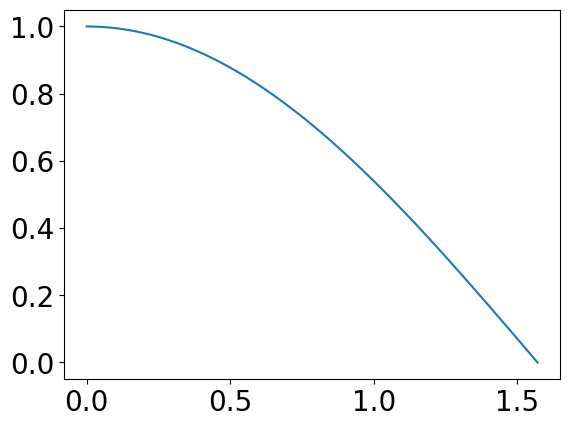

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0, 3.1416/2, num=100)
print(np.cos(x))
plt.plot(x, np.cos(x))
plt.axis('tight')
plt.show()

In [ ]:
1/np.cos(x)

array([ 1.00000000e+00,  1.00012589e+00,  1.00050371e+00,  1.00113395e+00,
        1.00201739e+00,  1.00315516e+00,  1.00454870e+00,  1.00619976e+00,
        1.00811048e+00,  1.01028328e+00,  1.01272096e+00,  1.01542668e+00,
        1.01840397e+00,  1.02165672e+00,  1.02518924e+00,  1.02900621e+00,
        1.03311276e+00,  1.03751446e+00,  1.04221732e+00,  1.04722785e+00,
        1.05255304e+00,  1.05820043e+00,  1.06417809e+00,  1.07049469e+00,
        1.07715952e+00,  1.08418250e+00,  1.09157427e+00,  1.09934618e+00,
        1.10751036e+00,  1.11607978e+00,  1.12506828e+00,  1.13449067e+00,
        1.14436273e+00,  1.15470135e+00,  1.16552458e+00,  1.17685169e+00,
        1.18870331e+00,  1.20110151e+00,  1.21406993e+00,  1.22763387e+00,
        1.24182047e+00,  1.25665885e+00,  1.27218025e+00,  1.28841828e+00,
        1.30540908e+00,  1.32319154e+00,  1.34180763e+00,  1.36130261e+00,
        1.38172539e+00,  1.40312890e+00,  1.42557047e+00,  1.44911230e+00,
        1.47382199e+00,  

[1.         1.00012588 1.00050354 1.00113309 1.00201469 1.00314854
 1.00453494 1.00617425 1.00806686 1.01021326 1.01261399 1.01526965
 1.01818091 1.0213485  1.02477322 1.02845594 1.03239758 1.03659913
 1.04106165 1.04578627 1.05077417 1.05602661 1.0615449  1.06733045
 1.07338471 1.0797092  1.08630551 1.09317531 1.10032032 1.10774234
 1.11544325 1.12342497 1.13168953 1.14023899 1.14907552 1.15820133
 1.16761873 1.17733008 1.18733784 1.19764451 1.2082527  1.21916507
 1.23038438 1.24191345 1.25375517 1.26591253 1.2783886  1.29118651
 1.30430948 1.31776082 1.33154392 1.34566224 1.36011934 1.37491886
 1.39006452 1.40556014 1.42140962 1.43761695 1.4541862  1.47112156
 1.48842728 1.50610773 1.52416734 1.54261068 1.56144237 1.58066717
 1.60028992 1.62031554 1.64074909 1.66159571 1.68286065 1.70454926
 1.726667   1.74921944 1.77221225 1.79565124 1.81954228 1.84389141
 1.86870476 1.89398856 1.91974918 1.94599311 1.97272696 1.99995746
 2.02769145 2.05593593 2.08469801 2.11398492 2.14380405 2.1741

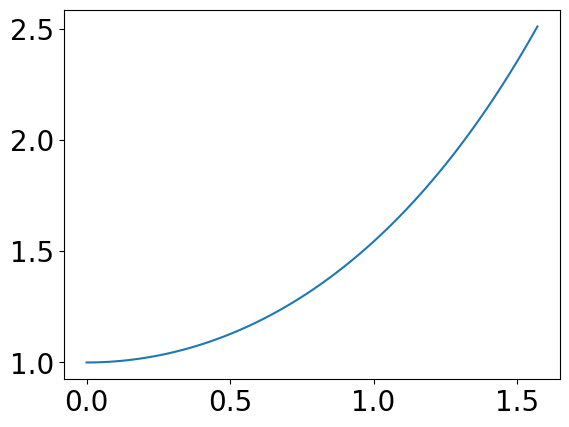

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0, 3.1416/2, num=100)
print(np.cosh(x))
plt.plot(x, np.cosh(x))
plt.axis('tight')
plt.show()

In [ ]:
p_df.loc[p_df["diameter"]==0.11, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow"]]

BlockID  diameter     slope  fill_ratio       y_n  velocity  desg_flow  \
26      631      0.11  0.010220    0.599854  0.065984  1.097403   0.006527   
53      799      0.11  0.009224    0.614209  0.067563  1.050681   0.006434   
58      836      0.11  0.050591    0.307275  0.033800  1.790514   0.004444   
59      840      0.11  0.004931    0.591650  0.065082  0.758742   0.004444   

    exact_flow  
26    0.006526  
53    0.006437  
58    0.004429  
59    0.004438

In [ ]:
b_df.loc[b_df["has_wwtp"]>0, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow", "PE"]]

BlockID  diameter  slope  fill_ratio  y_n  velocity  desg_flow  \
50      671       3.0    0.0         0.0  0.0       0.0   5.396751   

    exact_flow   PE  
50         0.0  0.0

In [ ]:
p_df.columns

Index(['BlockID', 'BasinID', 'CentreX', 'CentreY', 'Neighbours', 'Active',
       'pLU_RES', 'pLU_COM', 'pLU_ORC', 'pLU_LI',
       ...
       'tElev_up', 'tElev_down', 'terrain_slope', 'up_elevation',
       'down_elevation', 'up_depth', 'down_depth', 'avg_depth', 'pump',
       'drop'],
      dtype='object', length=251)

In [ ]:
p_df.loc[p_df["pump"]>0, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow", "pump", "drop", 'tElev_up', 'tElev_down', "up_depth", "down_depth"]]

BlockID  diameter     slope  fill_ratio       y_n   velocity  desg_flow  \
2       510      1.00  0.048890    0.550732  0.550732  10.138205   4.495272   
3       511      0.80  0.052490    0.799365  0.639492   9.922253   4.274069   
9       550      1.00  0.048890    0.584033  0.584033  10.359322   4.934371   
12      553      0.80  0.048890    0.798193  0.638555   9.575473   4.119053   
13      554      0.71  0.010496    0.758154  0.538290   4.080777   1.314242   
18      591      0.40  0.034306    0.646082  0.258433   4.865731   0.417825   
22      595      0.71  0.048890    0.679443  0.482405   8.629707   2.472033   
30      637      0.71  0.048890    0.676807  0.480533   8.621491   2.458700   
38      677      0.63  0.048890    0.665674  0.419375   7.927585   1.747311   
45      719      0.63  0.048890    0.584619  0.368310   7.615728   1.441492   
50      760      0.50  0.048890    0.655823  0.327911   6.768558   0.923675   

    exact_flow       pump  drop    tElev_up  tElev_down  up_depth  down_depth  
2     4.494071   6.876086   0.0  443.437500  441.546875      2.00   13.937500  
3     4.273877  12.187500   0.0  446.859375  443.437500      1.80    8.876086  
9     4.935151  11.937500   0.0  441.546875  435.734375      2.00   31.442440  
12    4.118746  10.363125   0.0  448.500000  446.859375      1.80   13.987500  
13    1.314146   7.371220   0.0  449.906250  448.500000      1.71    2.402973  
18    0.417890   8.008750   0.0  442.406250  441.546875      1.40    7.401770  
22    2.471616  11.343750   0.0  451.875000  448.500000      1.71   12.163125  
30    2.459039  12.904375   0.0  454.359375  451.875000      1.71   13.053750  
38    1.747373  13.456125   0.0  455.203125  454.359375      1.63   14.614375  
45    1.441743   9.646961   0.0  455.575125  455.203125      1.63   15.086125  
50    0.923673   9.172375   0.0  455.576125  455.575125      1.50   11.276961

In [ ]:
p_df.loc[p_df["drop"]>0, ["BlockID", "diameter", "slope", "fill_ratio", "y_n", "velocity", "desg_flow", "exact_flow", "pump", "drop", 'tElev_up', 'tElev_down', "up_depth", "down_depth"]]

BlockID  diameter     slope  fill_ratio       y_n  velocity  desg_flow  \
0       471     0.160  0.003073    0.573022  0.091684  0.760256   0.009057   
5       513     0.400  0.005359    0.675647  0.270259  1.946167   0.175833   
7       515     0.250  0.024859    0.667017  0.166754  3.054238   0.106234   
10      551     0.315  0.036239    0.543542  0.171216  4.020504   0.174023   
11      552     0.400  0.020219    0.506458  0.202583  3.422317   0.218611   
19      592     0.250  0.034306    0.619849  0.154962  3.512861   0.112256   
23      596     0.630  0.010496    0.612061  0.385598  3.583769   0.716667   
25      598     0.400  0.014529    0.469202  0.187681  2.806496   0.162500   
27      632     0.500  0.022760    0.479968  0.239984  4.117287   0.383637   
31      638     0.500  0.010496    0.620276  0.310138  3.085125   0.394722   
35      674     0.400  0.022760    0.674280  0.269712  4.008885   0.361389   
39      678     0.500  0.008728    0.627625  0.313812  2.823660   0.366389   
40      679     0.500  0.007513    0.546619  0.273309  2.496438   0.274167   
43      717     0.315  0.009667    0.573621  0.180690  2.119006   0.097973   
46      720     0.400  0.008728    0.670862  0.268345  2.479401   0.222222   
51      761     0.500  0.017899    0.563367  0.281683  3.897517   0.444167   
52      762     0.315  0.008728    0.611560  0.192641  2.058212   0.102778   
56      802     0.315  0.048890    0.625745  0.197110  4.906616   0.251721   
57      803     0.315  0.017899    0.685559  0.215951  3.043889   0.173333   
63      844     0.160  0.048890    0.486206  0.077793  2.839134   0.027555   

    exact_flow  pump          drop    tElev_up  tElev_down  up_depth  \
0     0.009063   0.0  2.210338e+00  446.453125  441.546875  3.850338   
5     0.175798   0.0  1.136868e-13  450.015625  448.500000  1.400000   
7     0.106203   0.0  5.000000e-02  454.078125  450.859375  1.250000   
10    0.174054   0.0  6.500000e-02  444.562500  442.406250  1.315000   
11    0.218504   0.0  2.400000e-01  447.296875  443.437500  1.400000   
19    0.112231   0.0  2.357605e+00  451.625000  442.406250  3.607605   
23    0.716538   0.0  1.300000e-01  452.312500  449.906250  1.630000   
25    0.162465   0.0  1.136868e-13  459.968750  455.859375  1.400000   
27    0.383718   0.0  1.000000e-01  445.015625  440.171875  1.500000   
31    0.394664   0.0  5.781250e-01  455.859375  452.312500  2.078125   
35    0.361303   0.0  3.171875e+00  454.625000  445.015625  4.571875   
39    0.366390   0.0  1.000000e-01  455.203125  454.359375  1.500000   
40    0.274210   0.0  4.843750e-01  456.968750  454.359375  1.984375   
43    0.098015   0.0  1.550000e-01  457.093750  455.203125  1.315000   
46    0.222185   0.0  5.000000e-01  458.171875  455.203125  1.900000   
51    0.444323   0.0  1.850000e-01  459.531250  455.575125  1.500000   
52    0.102814   0.0  1.136868e-13  460.640625  458.171875  1.315000   
56    0.251707   0.0  1.550000e-01  460.046875  455.576125  1.315000   
57    0.173308   0.0  1.136868e-13  464.593750  459.531250  1.315000   
63    0.027556   0.0  5.684342e-14  473.875000  460.046875  1.160000   

    down_depth  
0     1.160000  
5     1.400000  
7     3.003095  
10    9.408750  
11    3.259375  
19    1.250000  
23    2.192500  
25    1.400000  
27    3.093750  
31    1.500000  
35    1.400000  
39    2.401920  
40    1.500000  
43    2.158750  
46    1.400000  
51    2.606375  
52    1.315000  
56   10.672375  
57    1.315000  
63    1.160000


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED5C40D0>, <matplotlib.collections.PathCollection object at 0x00000271ECF392B0>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED5C40D0>, <matplotlib.collections.PathCollection object at 0x00000271ECF392B0>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED826D60>, <matplotlib.collections.PathCollection object at 0x00000271F29F5130>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED5C40D0>, <matplotlib.collections.PathCollection object at 0x00000271ECF392B0>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED826D60>, <matplotlib.collections.PathCollection object at 0x00000271F29F5130>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED08FE20>, <matplotlib.collections.PathCollection object at 0x00000271EA829640>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED5C40D0>, <matplotlib.collections.PathCollection object at 0x00000271ECF392B0>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED826D60>, <matplotlib.collections.PathCollection object at 0x00000271F29F5130>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED08FE20>, <matplotlib.collections.PathCollection object at 0x00000271EA829640>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271EA825D30>, <matplotlib.collections.PathCollection object at 0x00000271F940E250>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' .

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED5C40D0>, <matplotlib.collections.PathCollection object at 0x00000271ECF392B0>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED826D60>, <matplotlib.collections.PathCollection object at 0x00000271F29F5130>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271ED08FE20>, <matplotlib.collections.PathCollection object at 0x00000271EA829640>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271EA825D30>, <matplotlib.collections.PathCollection object at 0x00000271F940E250>, <matplotlib.lines.Line2D object at 0x00000271F2BAB8E0>, <matplotlib.collections.PathCollection object at 0x00000271F9460970>, <matplotlib.collections.PathCollection object at 0x00000271ED8D91F0>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


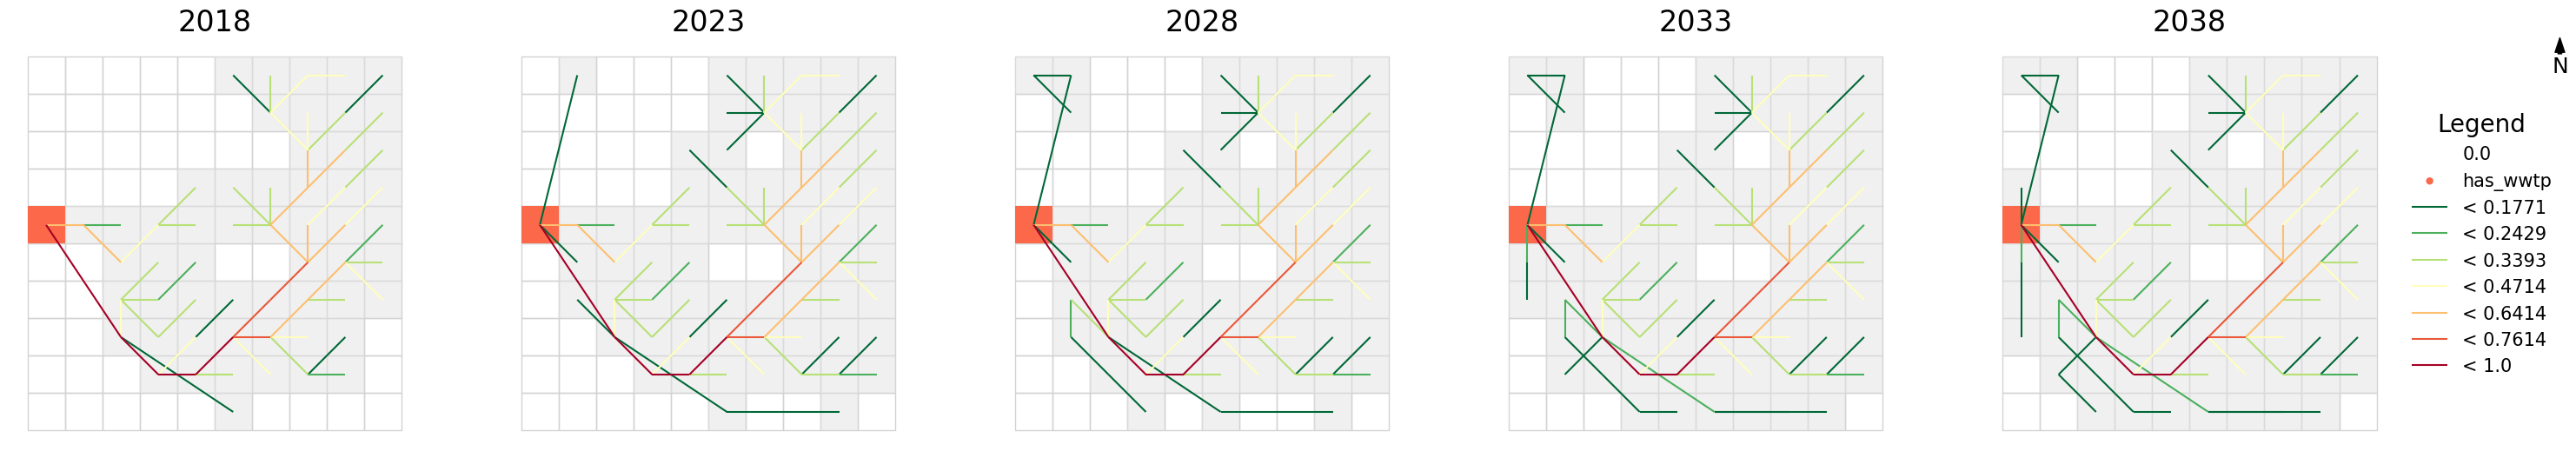

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="has_wwtp", units_poly = "[delta]", cmap_poly= pl.cm.Reds,
                    feature_lineStr="diameter", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["has_ww"], cmap_background_layers=[pl.cm.Greys],
                    path=output_path,
                    verbose=False,
                    )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F92E2130>, <matplotlib.collections.PathCollection object at 0x00000271F92F5160>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F92E2130>, <matplotlib.collections.PathCollection object at 0x00000271F92F5160>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F936A070>, <matplotlib.collections.PathCollection object at 0x00000271F9377190>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F92E2130>, <matplotlib.collections.PathCollection object at 0x00000271F92F5160>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F936A070>, <matplotlib.collections.PathCollection object at 0x00000271F9377190>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F93B9A30>, <matplotlib.collections.PathCollection object at 0x00000271F93DB670>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F92E2130>, <matplotlib.collections.PathCollection object at 0x00000271F92F5160>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F936A070>, <matplotlib.collections.PathCollection object at 0x00000271F9377190>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F93B9A30>, <matplotlib.collections.PathCollection object at 0x00000271F93DB670>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F93CF820>, <matplotlib.collections.PathCollection object at 0x00000271F32A43D0>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'diameter' .

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F92E2130>, <matplotlib.collections.PathCollection object at 0x00000271F92F5160>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F936A070>, <matplotlib.collections.PathCollection object at 0x00000271F9377190>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F93B9A30>, <matplotlib.collections.PathCollection object at 0x00000271F93DB670>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F93CF820>, <matplotlib.collections.PathCollection object at 0x00000271F32A43D0>, <matplotlib.lines.Line2D object at 0x00000271F322EEE0>, <matplotlib.collections.PathCollection object at 0x00000271F2A93100>, <matplotlib.collections.PathCollection object at 0x00000271EA859B80>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


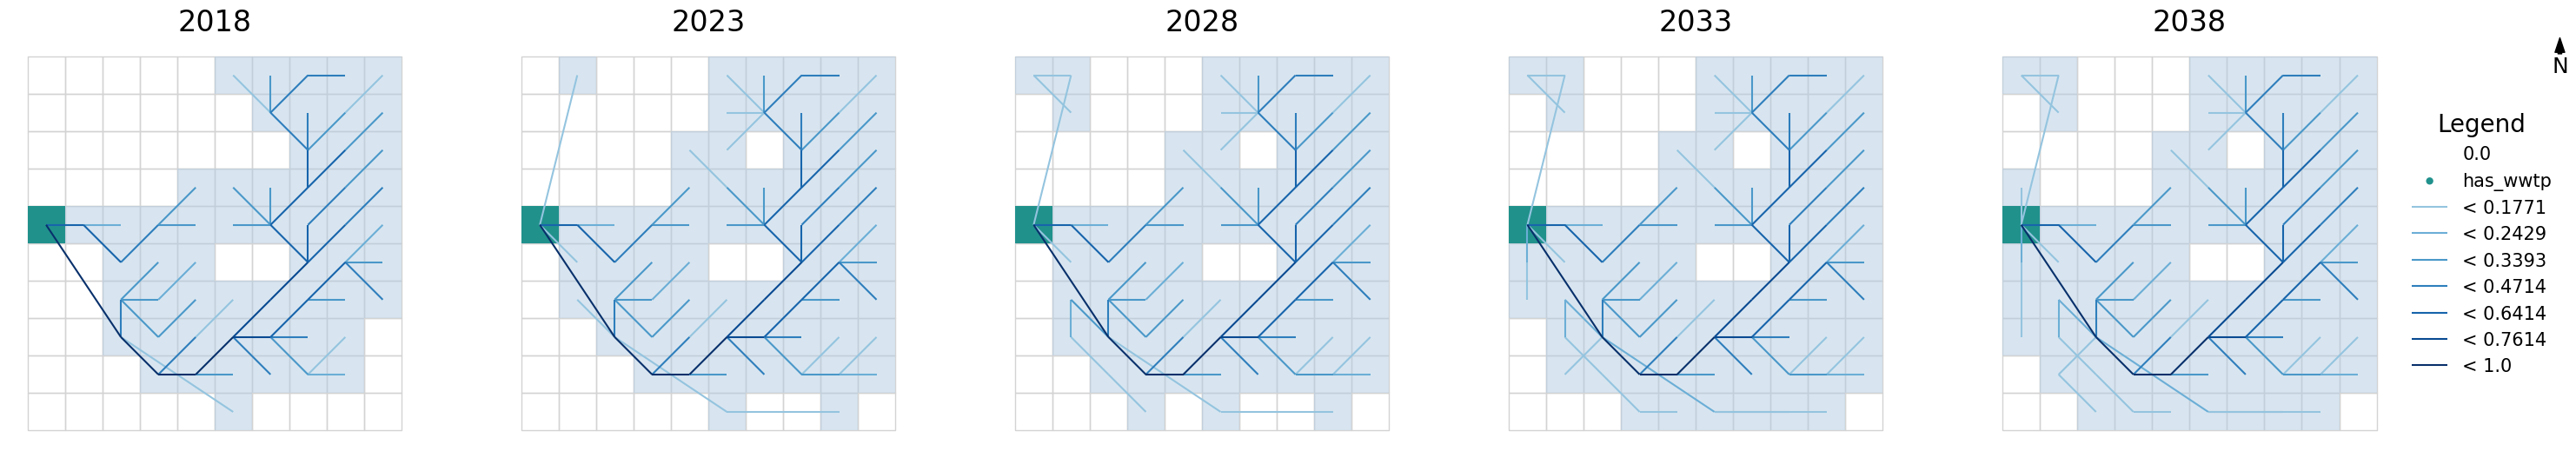

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                lineStr_dict=test_pipes_dict, 
                feature_poly="has_wwtp", units_poly = "[persons]", cmap_poly= pl.cm.viridis,
                feature_lineStr="diameter", units_lineStr = "[m]", cmap_lineStr=cmap_flow,
                module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                backgroud_layers=["has_ww"], cmap_background_layers=[pl.cm.Pastel1],
                path=output_path,
                verbose=False,
                )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271B59D5D30>, <matplotlib.collections.PathCollection object at 0x00000271F28CB520>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'slope' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271B59D5D30>, <matplotlib.collections.PathCollection object at 0x00000271F28CB520>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271F2A52520>, <matplotlib.collections.PathCollection object at 0x00000271F2A37A30>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'slope' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271B59D5D30>, <matplotlib.collections.PathCollection object at 0x00000271F28CB520>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271F2A52520>, <matplotlib.collections.PathCollection object at 0x00000271F2A37A30>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271EA87DD90>, <matplotlib.collections.PathCollection object at 0x00000271EA85BA90>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'slope' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271B59D5D30>, <matplotlib.collections.PathCollection object at 0x00000271F28CB520>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271F2A52520>, <matplotlib.collections.PathCollection object at 0x00000271F2A37A30>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271EA87DD90>, <matplotlib.collections.PathCollection object at 0x00000271EA85BA90>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271EA8651C0>, <matplotlib.collections.PathCollection object at 0x00000271F944CD00>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'slope' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271B59D5D30>, <matplotlib.collections.PathCollection object at 0x00000271F28CB520>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271F2A52520>, <matplotlib.collections.PathCollection object at 0x00000271F2A37A30>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271EA87DD90>, <matplotlib.collections.PathCollection object at 0x00000271EA85BA90>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271EA8651C0>, <matplotlib.collections.PathCollection object at 0x00000271F944CD00>, <matplotlib.lines.Line2D object at 0x00000271F29FBF70>, <matplotlib.collections.PathCollection object at 0x00000271F9466040>, <matplotlib.collections.PathCollection object at 0x00000271ECF03550>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


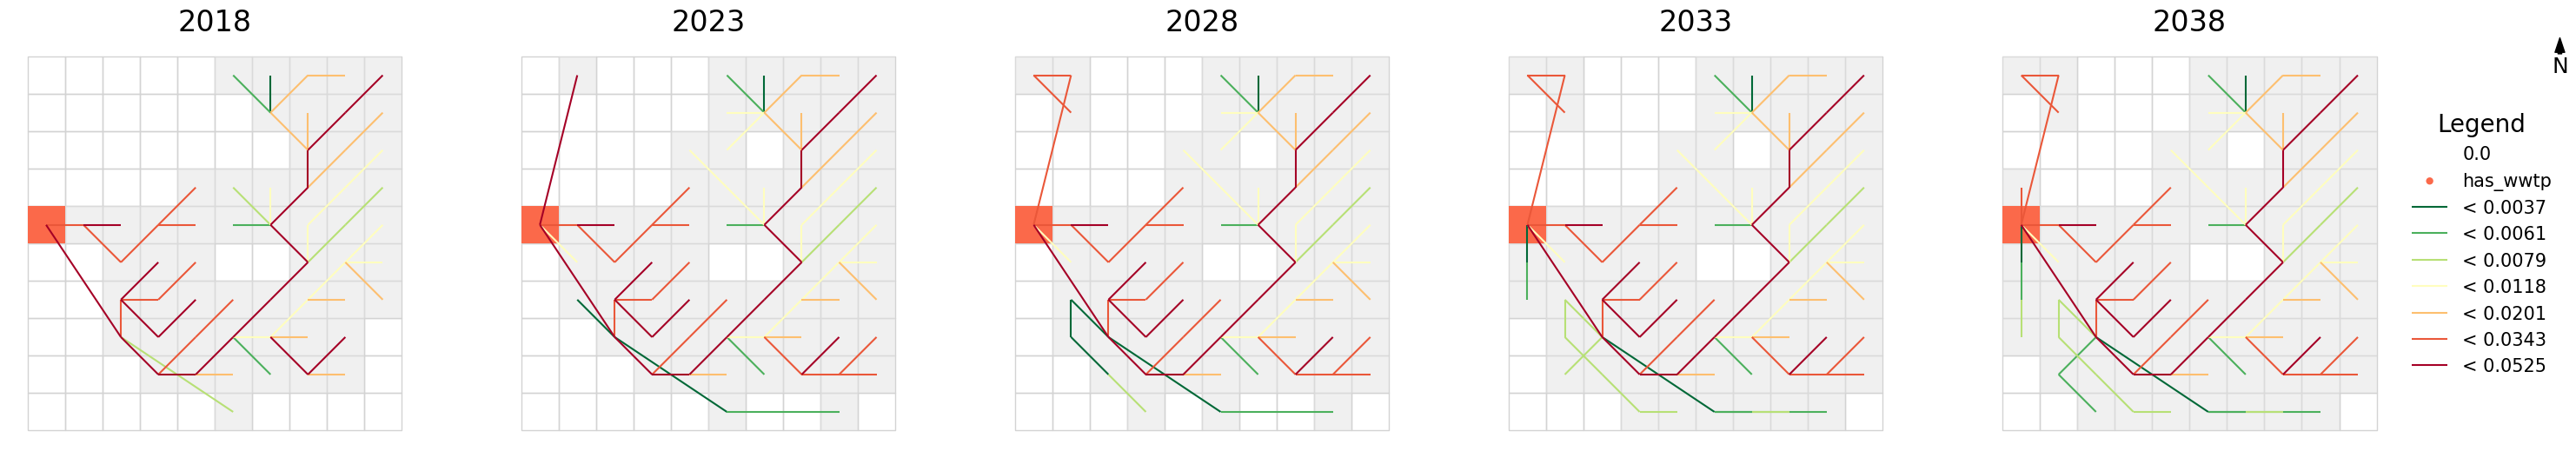

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="has_wwtp", units_poly = "[delta]", cmap_poly= pl.cm.Reds,
                    feature_lineStr="slope", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["has_ww"], cmap_background_layers=[pl.cm.Greys],
                    path=output_path,
                    verbose=False,
                    )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED678310>, <matplotlib.collections.PathCollection object at 0x00000271ED72CE80>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'velocity' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED678310>, <matplotlib.collections.PathCollection object at 0x00000271ED72CE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED75C9A0>, <matplotlib.collections.PathCollection object at 0x00000271ED7AA0A0>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'velocity' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED678310>, <matplotlib.collections.PathCollection object at 0x00000271ED72CE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED75C9A0>, <matplotlib.collections.PathCollection object at 0x00000271ED7AA0A0>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED801910>, <matplotlib.collections.PathCollection object at 0x00000271ED80DE80>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'velocity' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED678310>, <matplotlib.collections.PathCollection object at 0x00000271ED72CE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED75C9A0>, <matplotlib.collections.PathCollection object at 0x00000271ED7AA0A0>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED801910>, <matplotlib.collections.PathCollection object at 0x00000271ED80DE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED854670>, <matplotlib.collections.PathCollection object at 0x00000271ED867400>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'velocity' .

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED678310>, <matplotlib.collections.PathCollection object at 0x00000271ED72CE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED75C9A0>, <matplotlib.collections.PathCollection object at 0x00000271ED7AA0A0>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED801910>, <matplotlib.collections.PathCollection object at 0x00000271ED80DE80>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ED854670>, <matplotlib.collections.PathCollection object at 0x00000271ED867400>, <matplotlib.lines.Line2D object at 0x00000271ED621EB0>, <matplotlib.collections.PathCollection object at 0x00000271ECEF4EB0>, <matplotlib.collections.PathCollection object at 0x00000271ECEF4C70>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


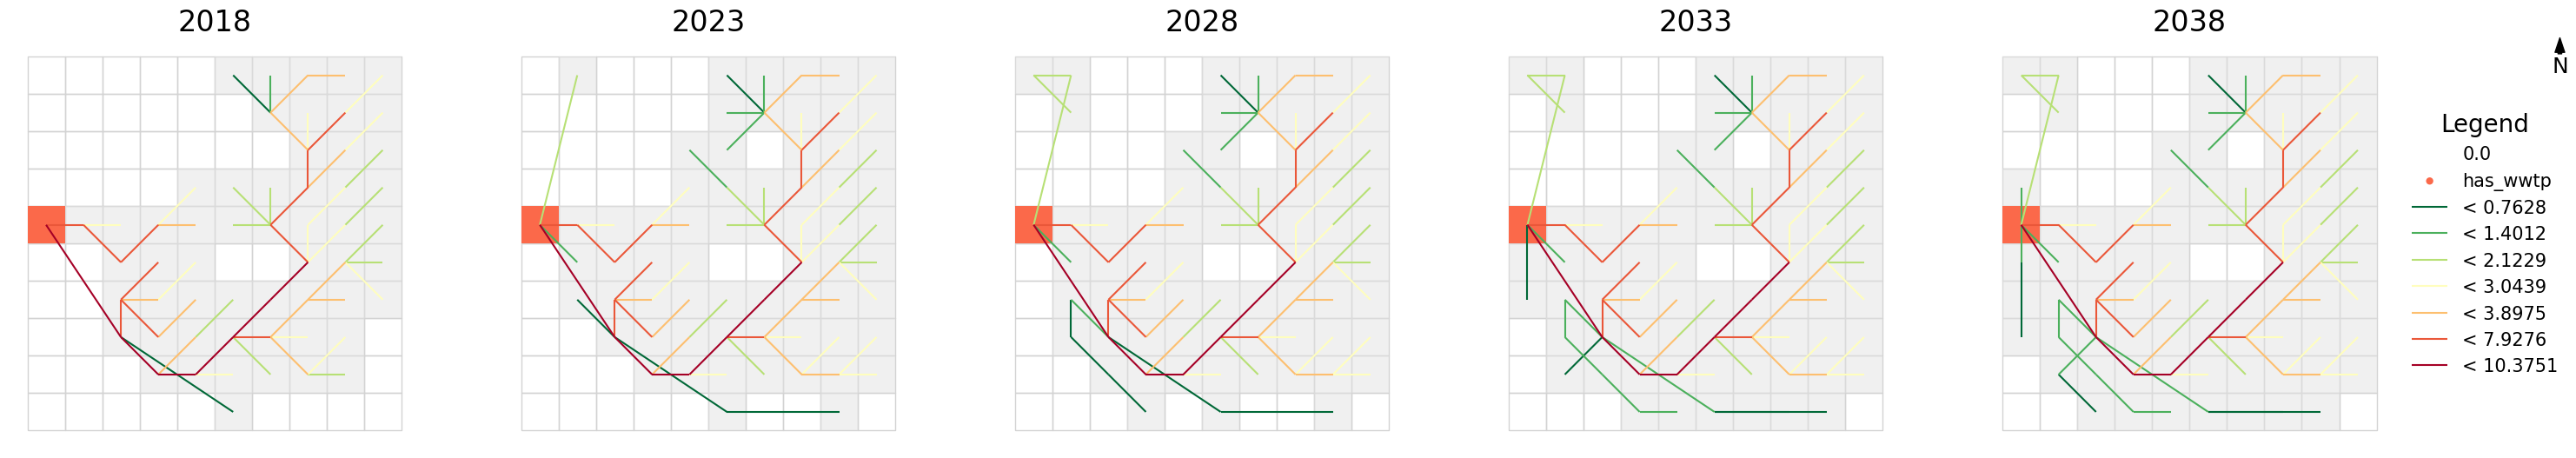

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="has_wwtp", units_poly = "[delta]", cmap_poly= pl.cm.Reds,
                    feature_lineStr="velocity", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["has_ww"], cmap_background_layers=[pl.cm.Greys],
                    path=output_path,
                    verbose=False,
                    )

In [ ]:
test_pipes_dict[2023].columns

Index(['BlockID', 'BasinID', 'CentreX', 'CentreY', 'Neighbours', 'Active',
       'pLU_RES', 'pLU_COM', 'pLU_ORC', 'pLU_LI',
       ...
       'tElev_up', 'tElev_down', 'terrain_slope', 'up_elevation',
       'down_elevation', 'up_depth', 'down_depth', 'avg_depth', 'pump',
       'drop'],
      dtype='object', length=251)


--------2018 ---------- 
Plotting polygons feature: 'blk_elev' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271EA806580>, <matplotlib.collections.PathCollection object at 0x00000271F295E190>, <matplotlib.collections.PathCollection object at 0x00000271F2903610>, <matplotlib.collections.PathCollection object at 0x00000271F2917580>, <matplotlib.collections.PathCollection object at 0x00000271F2AFB3A0>, <matplotlib.collections.PathCollection object at 0x00000271F2A12EE0>, <matplotlib.collections.PathCollection object at 0x00000271EA884A30>] ['\nblk_elev', '< 440.8192', '< 448.0312', '< 453.1518', '< 456.2612', '< 458.3616', '< 461.346', '< 477.4531']
----------EN OF HANDLES-----------

Plotting pipes 'down_depth' ...

--------2023 ---------- 
Plotting polygons feature: 'blk_elev' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271EA806580>, <matplotlib.collections.PathCollection object at 0x00000271F295E190>, <matplotlib.collections.PathCollection object at 0x00000271F2903610>, <matplotlib.collections.PathCollection object at 0x00000271F2917580>, <matplotlib.collections.PathCollection object at 0x00000271F2AFB3A0>, <matplotlib.collections.PathCollection object at 0x00000271F2A12EE0>, <matplotlib.collections.PathCollection object at 0x00000271EA884A30>, <matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271F29C7AC0>, <matplotlib.collections.PathCollection object at 0x00000271F3237610>, <matplotlib.collections.PathCollection object at 0x00000271F32370A0>, <matplotlib.collections.PathCollection object at 0x00000271F2ADBA30>, <matplotlib.collections.PathCollection object at 0x00000271F93FDE50>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271EA806580>, <matplotlib.collections.PathCollection object at 0x00000271F295E190>, <matplotlib.collections.PathCollection object at 0x00000271F2903610>, <matplotlib.collections.PathCollection object at 0x00000271F2917580>, <matplotlib.collections.PathCollection object at 0x00000271F2AFB3A0>, <matplotlib.collections.PathCollection object at 0x00000271F2A12EE0>, <matplotlib.collections.PathCollection object at 0x00000271EA884A30>, <matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271F29C7AC0>, <matplotlib.collections.PathCollection object at 0x00000271F3237610>, <matplotlib.collections.PathCollection object at 0x00000271F32370A0>, <matplotlib.collections.PathCollection object at 0x00000271F2ADBA30>, <matplotlib.collections.PathCollection object at 0x00000271F93FDE50>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271EA806580>, <matplotlib.collections.PathCollection object at 0x00000271F295E190>, <matplotlib.collections.PathCollection object at 0x00000271F2903610>, <matplotlib.collections.PathCollection object at 0x00000271F2917580>, <matplotlib.collections.PathCollection object at 0x00000271F2AFB3A0>, <matplotlib.collections.PathCollection object at 0x00000271F2A12EE0>, <matplotlib.collections.PathCollection object at 0x00000271EA884A30>, <matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271F29C7AC0>, <matplotlib.collections.PathCollection object at 0x00000271F3237610>, <matplotlib.collections.PathCollection object at 0x00000271F32370A0>, <matplotlib.collections.PathCollection object at 0x00000271F2ADBA30>, <matplotlib.collections.PathCollection object at 0x00000271F93FDE50>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271EA806580>, <matplotlib.collections.PathCollection object at 0x00000271F295E190>, <matplotlib.collections.PathCollection object at 0x00000271F2903610>, <matplotlib.collections.PathCollection object at 0x00000271F2917580>, <matplotlib.collections.PathCollection object at 0x00000271F2AFB3A0>, <matplotlib.collections.PathCollection object at 0x00000271F2A12EE0>, <matplotlib.collections.PathCollection object at 0x00000271EA884A30>, <matplotlib.lines.Line2D object at 0x00000271F2A52E50>, <matplotlib.collections.PathCollection object at 0x00000271F29C7AC0>, <matplotlib.collections.PathCollection object at 0x00000271F3237610>, <matplotlib.collections.PathCollection object at 0x00000271F32370A0>, <matplotlib.collections.PathCollection object at 0x00000271F2ADBA30>, <matplotlib.collections.PathCollection object at 0x00000271F93FDE50>, <matplotlib.collections.Path

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


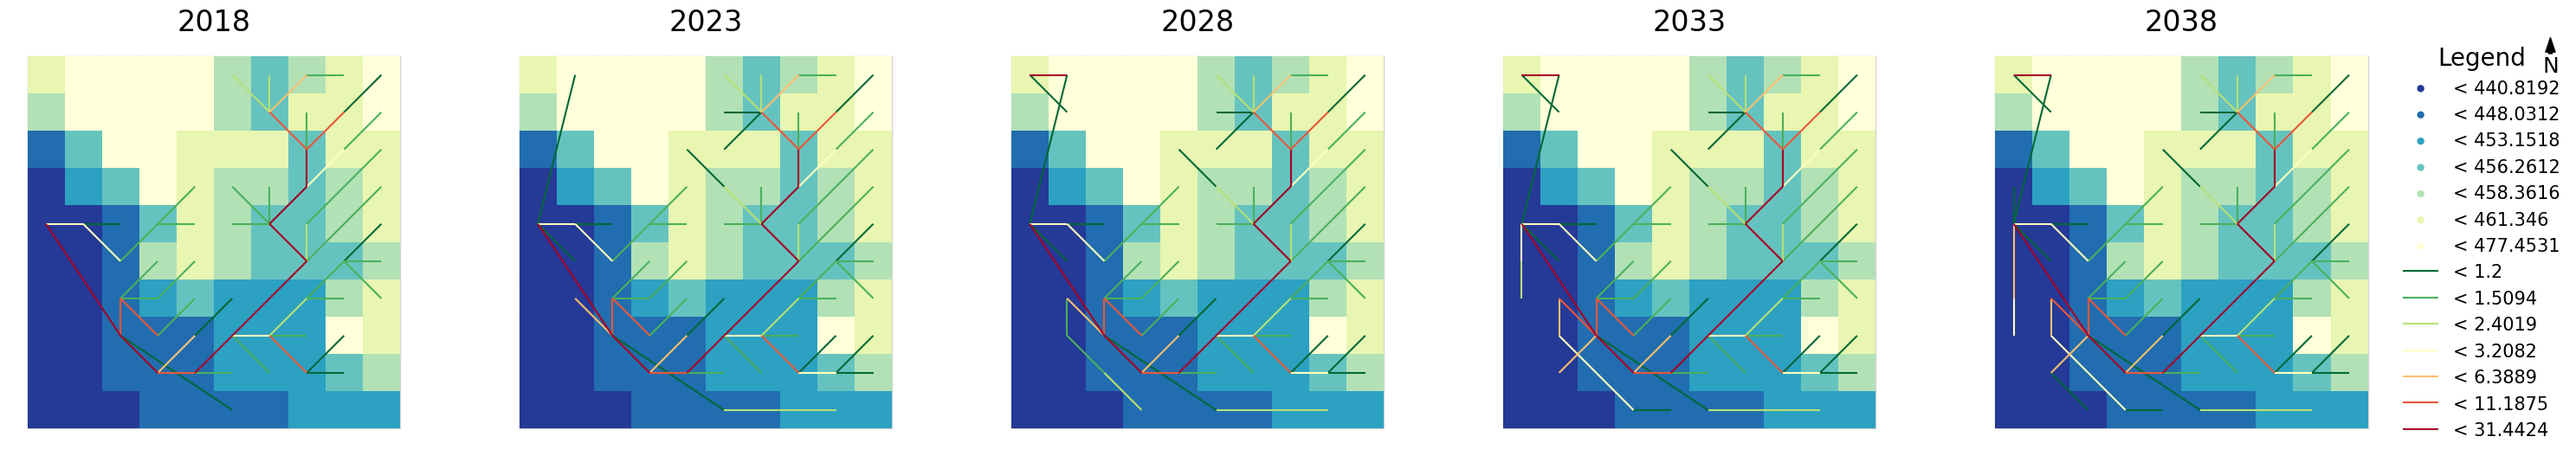

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="blk_elev", units_poly = "[delta]", cmap_poly= pl.cm.YlGnBu_r,
                    feature_lineStr="down_depth", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["drop", "pump"], cmap_background_layers=[pl.cm.Greys, pl.cm.Blues],
                    path=output_path,
                    verbose=False,
                    )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F93A06D0>, <matplotlib.collections.PathCollection object at 0x00000271F93A0D00>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'down_depth' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F93A06D0>, <matplotlib.collections.PathCollection object at 0x00000271F93A0D00>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F3265970>, <matplotlib.collections.PathCollection object at 0x00000271F3246310>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'down_depth' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F93A06D0>, <matplotlib.collections.PathCollection object at 0x00000271F93A0D00>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F3265970>, <matplotlib.collections.PathCollection object at 0x00000271F3246310>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F31FFC40>, <matplotlib.collections.PathCollection object at 0x00000271F31D2B50>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'down_depth' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F93A06D0>, <matplotlib.collections.PathCollection object at 0x00000271F93A0D00>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F3265970>, <matplotlib.collections.PathCollection object at 0x00000271F3246310>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F31FFC40>, <matplotlib.collections.PathCollection object at 0x00000271F31D2B50>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271ECFA5190>, <matplotlib.collections.PathCollection object at 0x00000271ECFA5E80>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'down_depth'

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:392: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()
c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F93A06D0>, <matplotlib.collections.PathCollection object at 0x00000271F93A0D00>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F3265970>, <matplotlib.collections.PathCollection object at 0x00000271F3246310>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F31FFC40>, <matplotlib.collections.PathCollection object at 0x00000271F31D2B50>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271ECFA5190>, <matplotlib.collections.PathCollection object at 0x00000271ECFA5E80>, <matplotlib.lines.Line2D object at 0x00000271F32ABE20>, <matplotlib.collections.PathCollection object at 0x00000271F2979580>, <matplotlib.collections.PathCollection object at 0x00000271F29790A0>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


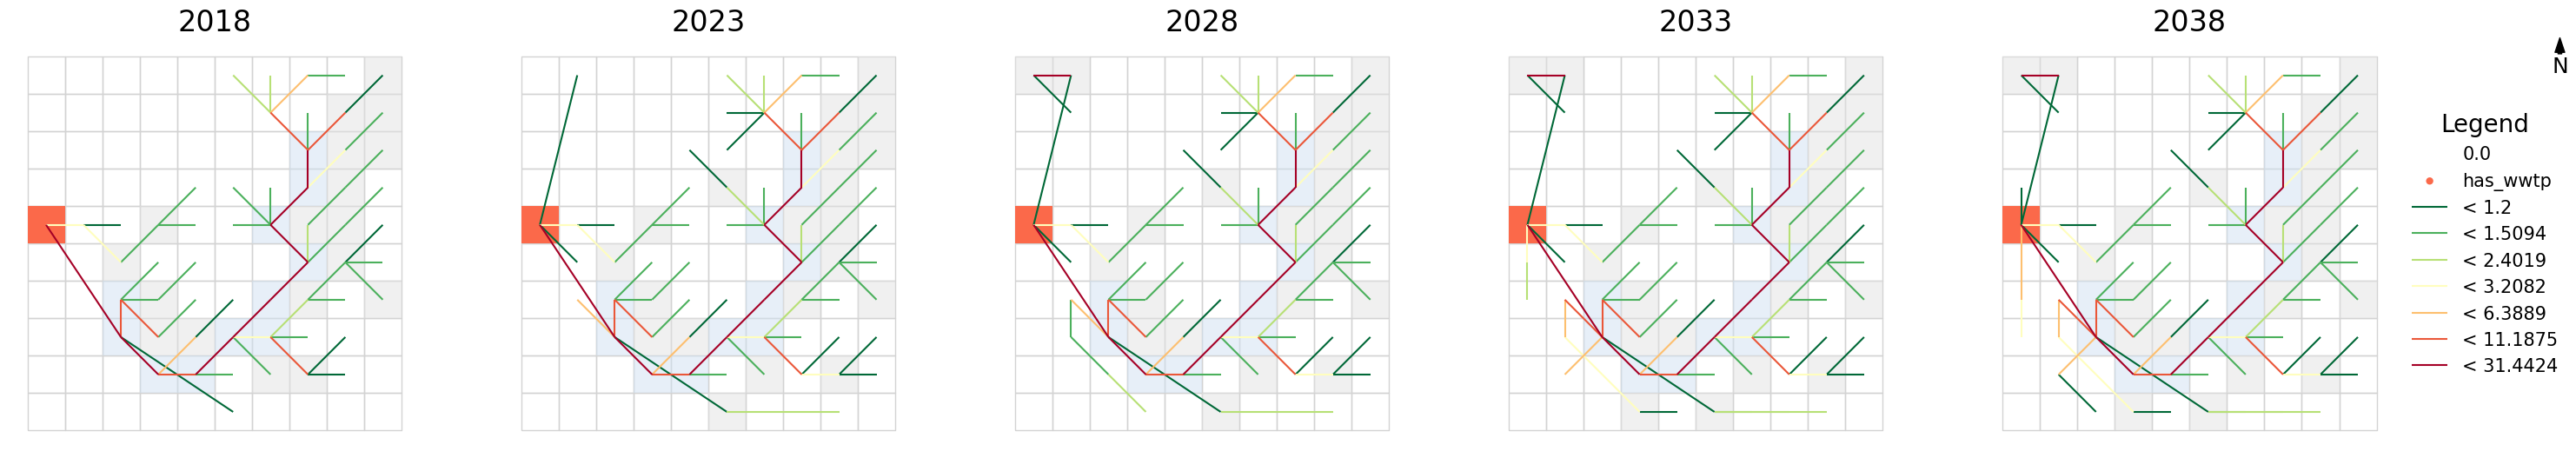

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="has_wwtp", units_poly = "[delta]", cmap_poly= pl.cm.Reds,
                    feature_lineStr="down_depth", units_lineStr = "[type]", cmap_lineStr=pl.cm.RdYlGn_r,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    backgroud_layers=["drop", "pump"], cmap_background_layers=[pl.cm.Greys, pl.cm.Blues],
                    path=output_path,
                    verbose=False,
                    )


--------2018 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F3286FA0>, <matplotlib.collections.PathCollection object at 0x00000271F28F8250>] ['\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2023 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F3286FA0>, <matplotlib.collections.PathCollection object at 0x00000271F28F8250>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED848370>, <matplotlib.collections.PathCollection object at 0x00000271ED81B280>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2028 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F3286FA0>, <matplotlib.collections.PathCollection object at 0x00000271F28F8250>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED848370>, <matplotlib.collections.PathCollection object at 0x00000271ED81B280>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED831910>, <matplotlib.collections.PathCollection object at 0x00000271ED7CBD30>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' ...

--------2033 ---------- 
Plotting polygons feature: 'has_wwtp' ...


c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F3286FA0>, <matplotlib.collections.PathCollection object at 0x00000271F28F8250>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED848370>, <matplotlib.collections.PathCollection object at 0x00000271ED81B280>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED831910>, <matplotlib.collections.PathCollection object at 0x00000271ED7CBD30>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F93CA790>, <matplotlib.collections.PathCollection object at 0x00000271F2998430>] ['\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp', '\nhas_wwtp', '0.0', 'has_wwtp']
----------EN OF HANDLES-----------

Plotting pipes 'desg_flow' 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:627: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  hd, lb = ax.get_legend_handles_labels()


HANDLES ANA LABELS
[<matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F3286FA0>, <matplotlib.collections.PathCollection object at 0x00000271F28F8250>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED848370>, <matplotlib.collections.PathCollection object at 0x00000271ED81B280>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED831910>, <matplotlib.collections.PathCollection object at 0x00000271ED7CBD30>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271F93CA790>, <matplotlib.collections.PathCollection object at 0x00000271F2998430>, <matplotlib.lines.Line2D object at 0x00000271F2A27100>, <matplotlib.collections.PathCollection object at 0x00000271ED6AC4F0>, <matplotlib.collections.PathCollection object at 0x00000271ED6A82E0>] 

c:\users\duquevna\dropbox\010_phd\01_python\snd_manual\ssnd\help_functions\plot_maps.py:819: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  a, b = ax.get_legend_handles_labels()


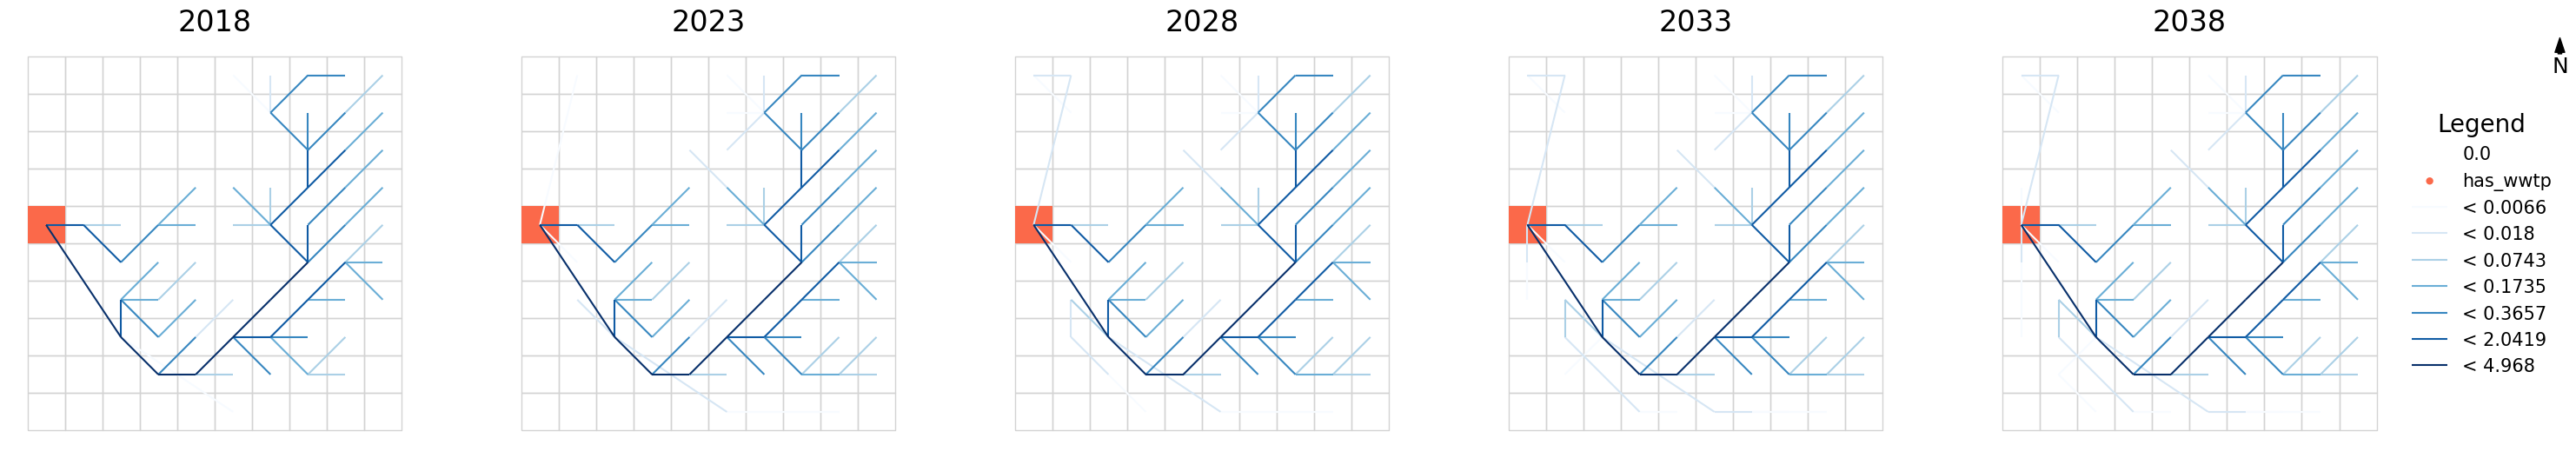

In [ ]:
plot_development(poly_dict=test_blocks_dict, 
                    lineStr_dict=test_pipes_dict, 
                    feature_poly="has_wwtp", units_poly = "[delta]", cmap_poly= pl.cm.Reds,
                    feature_lineStr="desg_flow", units_lineStr = "[type]", cmap_lineStr=pl.cm.Blues,
                    module=module, connectivity=connectivity, case_study=case_study, plot=plot, 
                    # backgroud_layers=["drop", "pump"], cmap_background_layers=[pl.cm.Greys, pl.cm.Blues],
                    path=output_path,
                    verbose=False,
                    )

In [ ]:
sum(test_pipes_dict[2018]["horiz_dist"])/1000

14.858872734322654

In [ ]:
sum(test_pipes_dict[2038]["horiz_dist"])/1000

21.31192098419238

In [ ]:
(sum(test_pipes_dict[2038]["horiz_dist"])-sum(test_pipes_dict[2018]["horiz_dist"]))/sum(test_pipes_dict[2018]["horiz_dist"])

0.4342892200000991

In [ ]:
6/14



0.42857142857142855

In [ ]:
sum(test_pipes_dict[2018].loc[test_pipes_dict[2018]["Population"]>0, "Population"])

1897400.0

In [ ]:
test_pipes_dict

NameError: name 'test_pipes_dict' is not defined